In [1]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_cleaning import clean_dataset
from data_utils import load_movie_data_limited, load_and_preprocess_data, load_movie_data, cluster_genres, \
    _load_all_data_with_embeddings, expand_by_genre
from analysis.stats_data import calculate_genre_drift, plot_genre_drift, prepare_heatmap_data, plot_clustermap, \
    plot_standard_heatmap, calculate_genre_convergence, plot_pairwise_convergence, plot_mean_convergence
from chunking.calculations import compute_cosine_distance, calculate_drift_vector

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))

DATA_DIR = str(BASE_DIR / "data")
OUTPUT_DIR = None
N_MOVIES_PER_YEAR = None
RANDOM_SEED = 42
START_YEAR = 1960
TOP_X_GENRES = 5
BIN_SIZE = 10


# Load clean data with new genres, expand the genres so the movies are repeated per each genre
df_movies = _load_all_data_with_embeddings(DATA_DIR)
print(df_movies.shape)
df_movies = await clean_dataset(df_movies, new_event_loop=False)
print(df_movies.shape)
df_movies = expand_by_genre(df_movies)
print(df_movies.shape)


/home/martin/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(87718, 33)
Original dataset size: 87718
After filtering movies without plot: 87718
After filtering non-movies: 86941
After removing single-occurrence genres from genre column: 86941
After filtering movies with plot length > 14000 chars: 86922
(86922, 34)
(128516, 34)


# Genre drift velocity

For each genre, we calculate how much the genre has changed each year compared to the previous year (drift distance) and the cumulative change over time (cumulative change).


Drift DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1487
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1488 non-null   int64  
 1   new_genre           1488 non-null   object 
 2   avg_embedding       1488 non-null   object 
 3   next_avg_embedding  1488 non-null   object 
 4   drift_distance      1488 non-null   float64
 5   cumulative_change   1488 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB
None


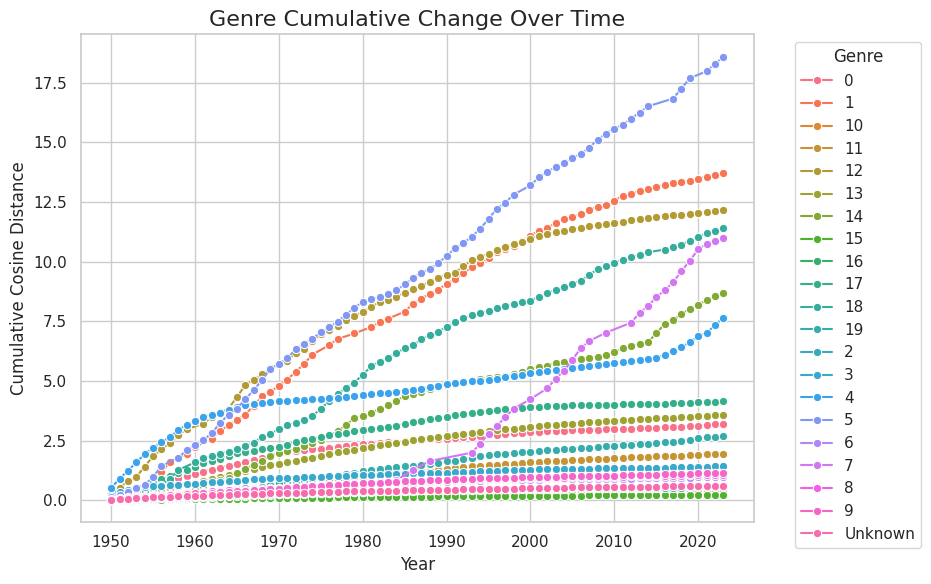

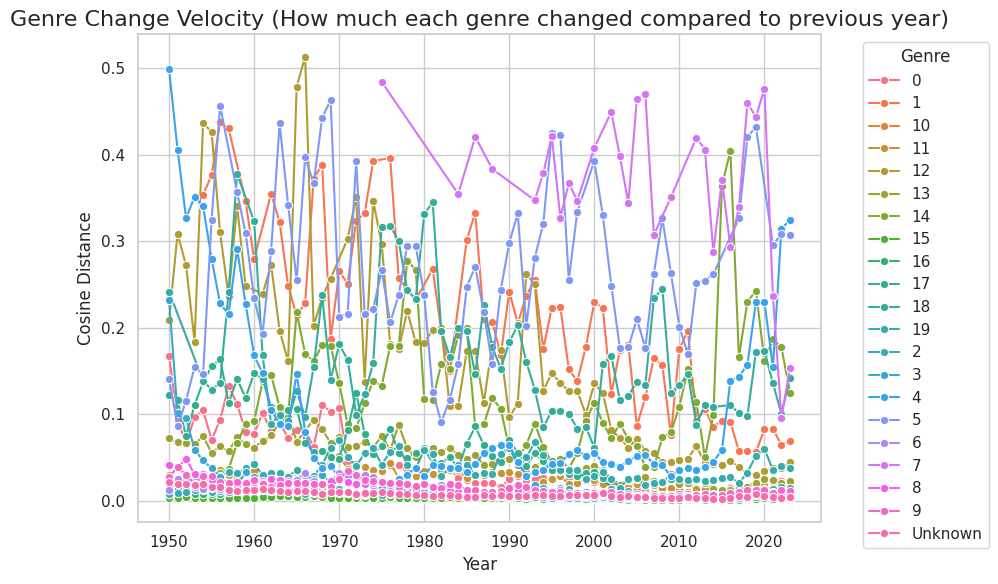

In [2]:
drift_df, group_df = calculate_genre_drift(df_movies)


print("\nDrift DataFrame Info:")
print(drift_df.info())

plot_genre_drift(
    df=drift_df,
    y_column='cumulative_change',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_distance',
    title='Genre Change Velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)


# Heatmaps of genre drift

For each genre, we group by 5-10 years and calculate the average drift distance between those time bins. We then plot heatmaps and clustermaps to visualize the relationships between different time periods within each genre. The idea is to see if the change is converging or diverging over time.

Orange colors indicate positive drift in a specific dimension, while blue colors indicate negative drift. The intensity of the color represents the magnitude of the drift.

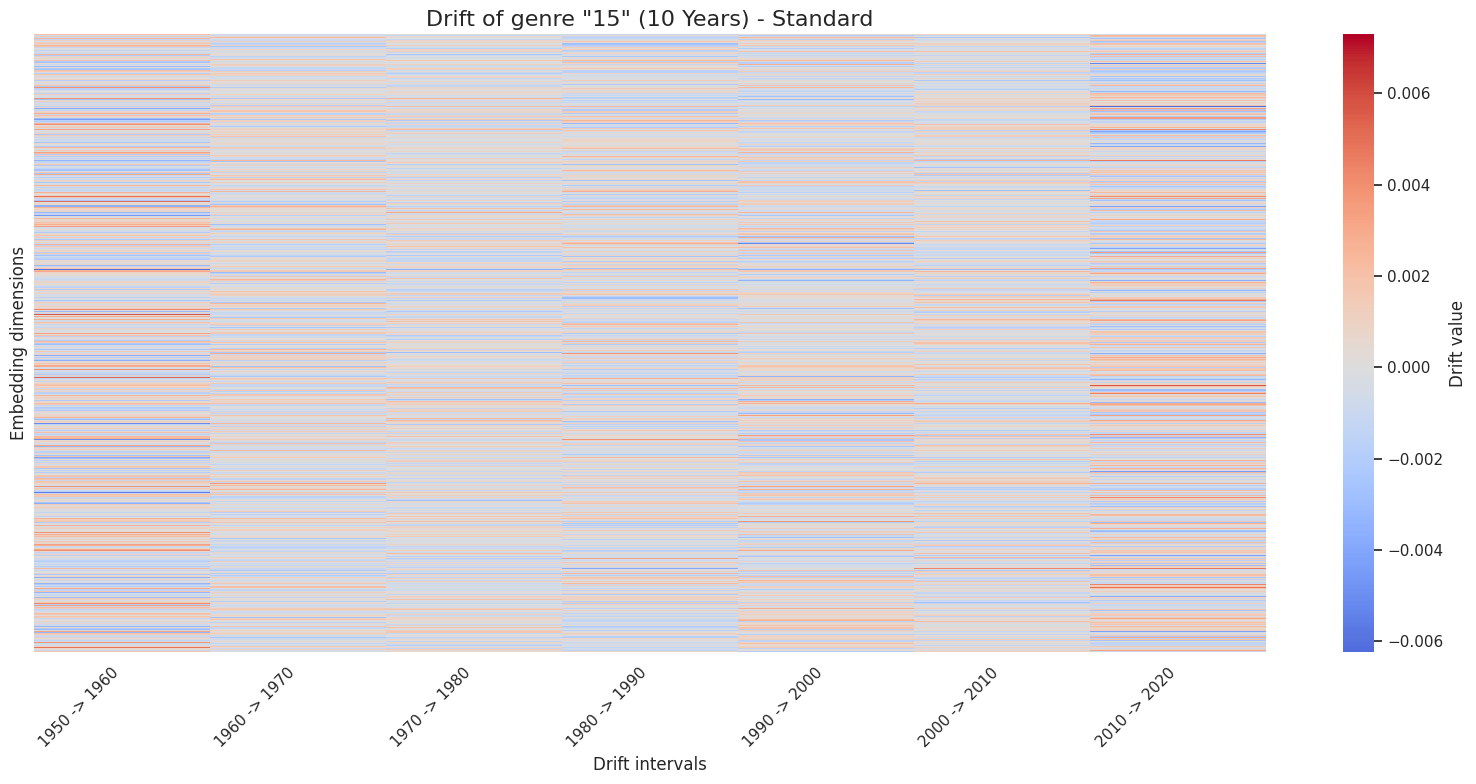

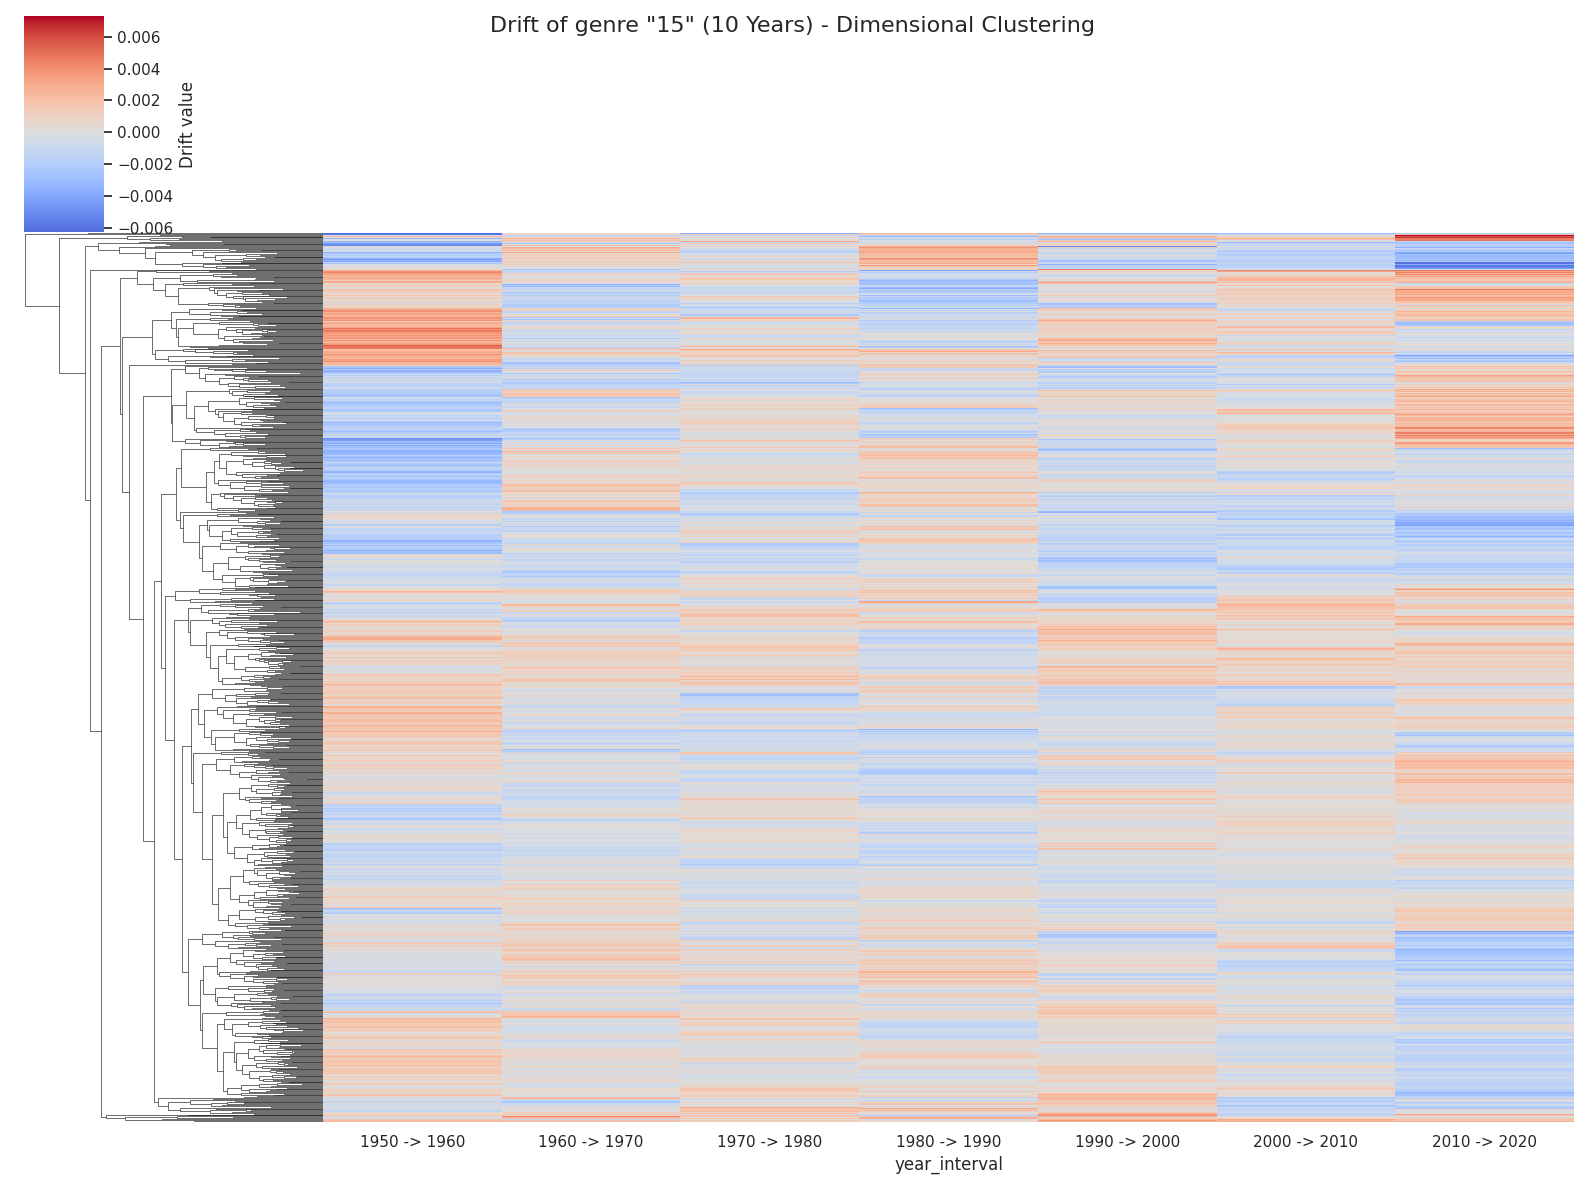

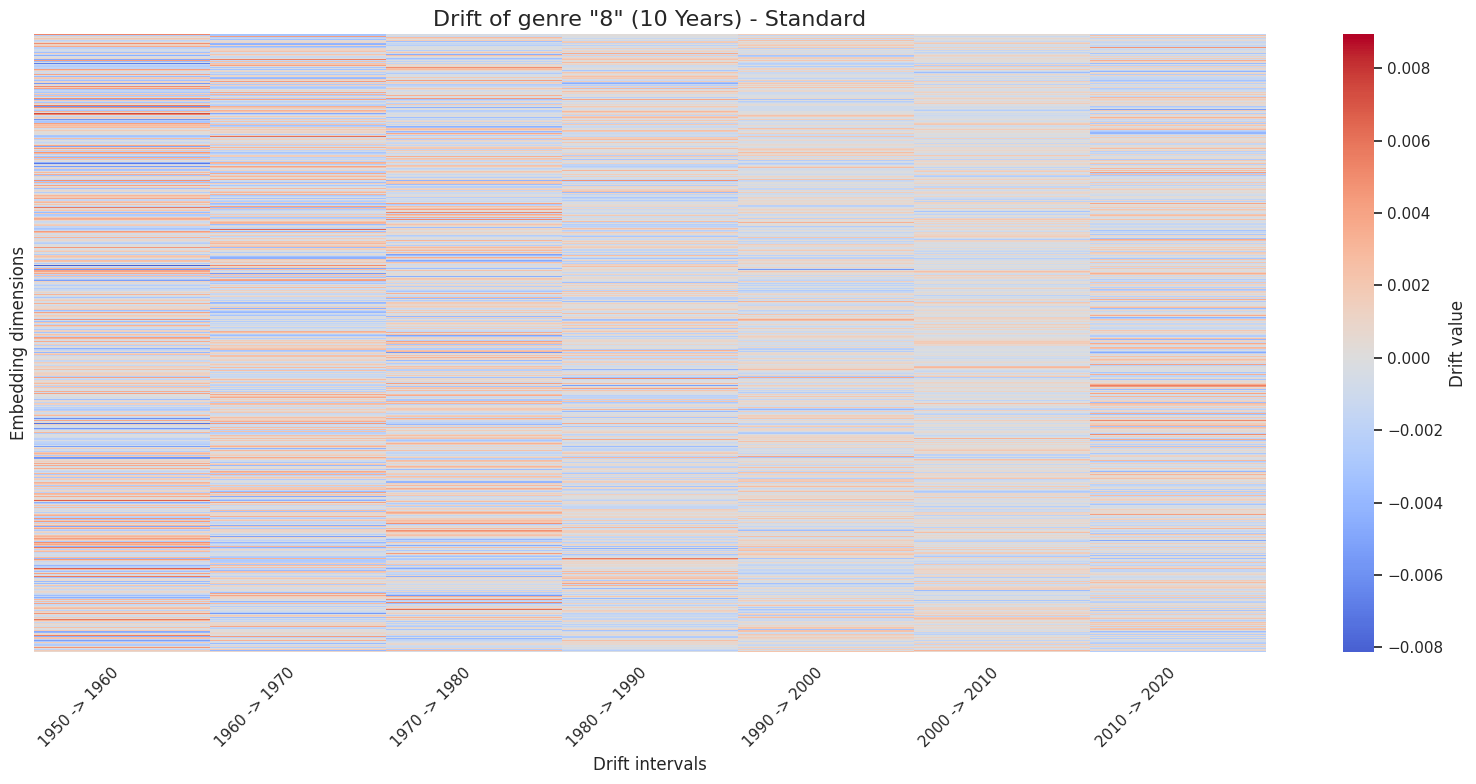

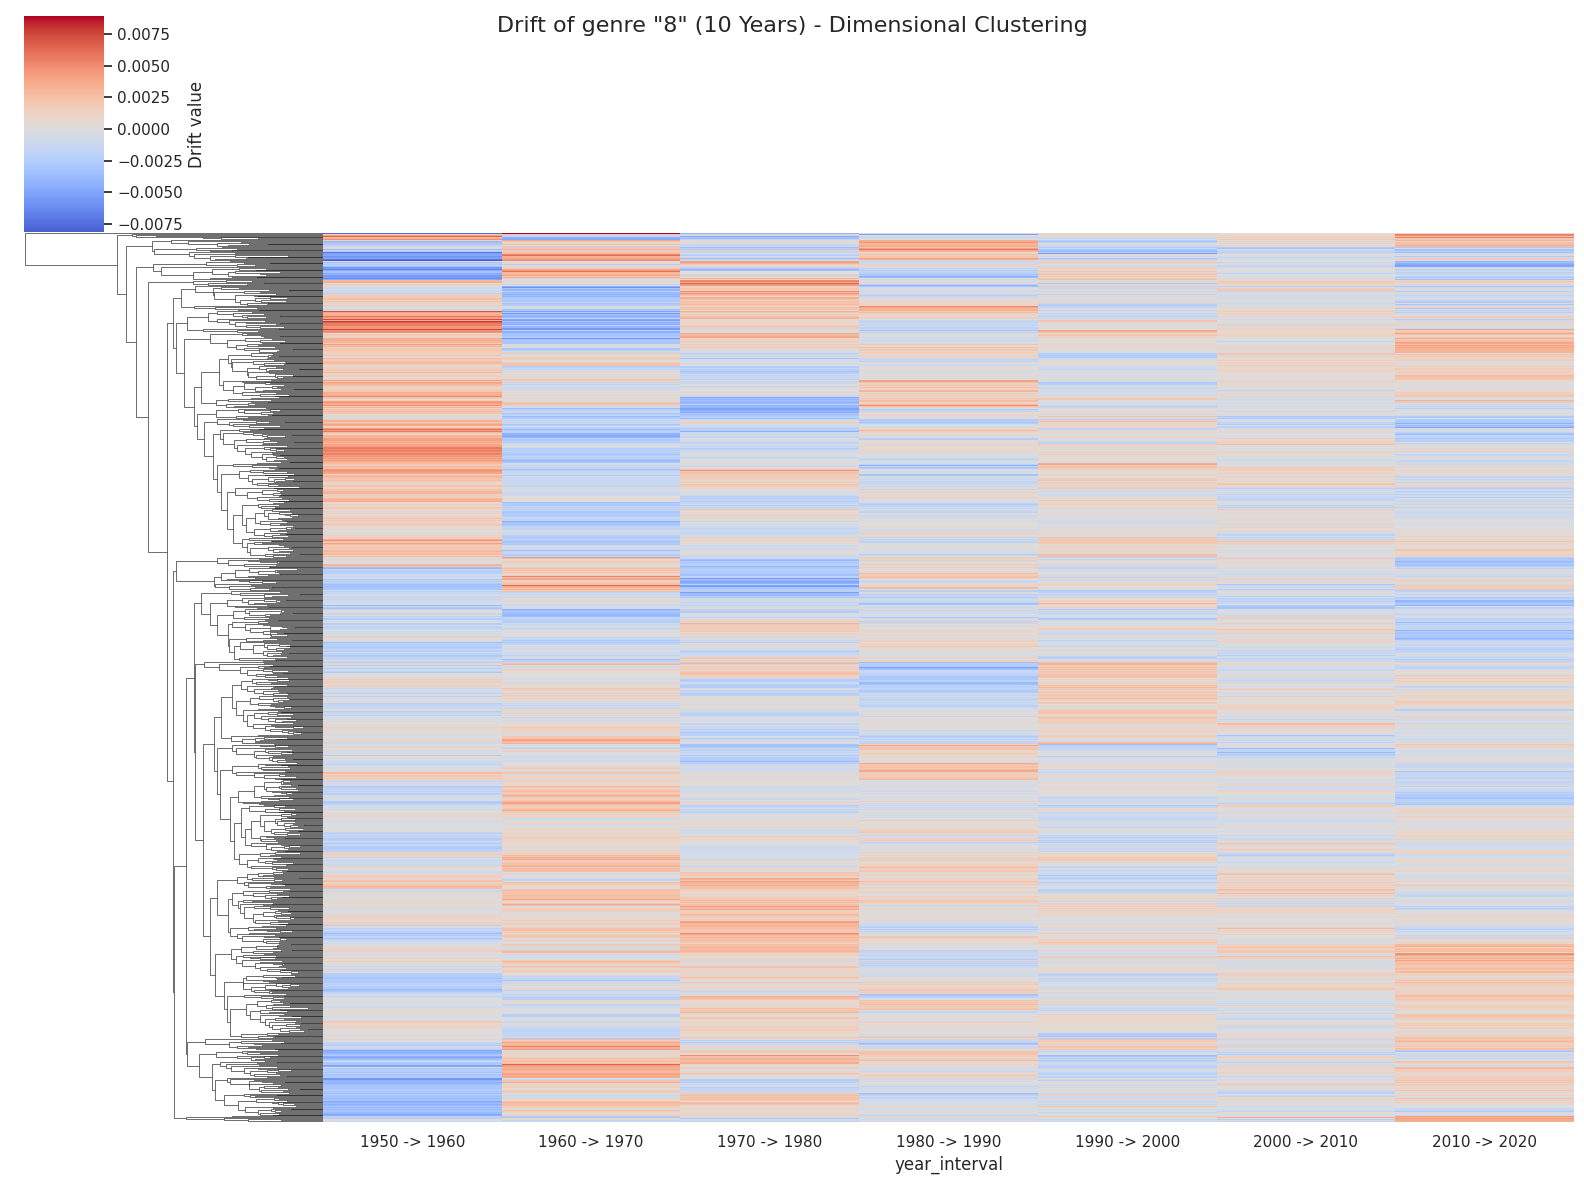

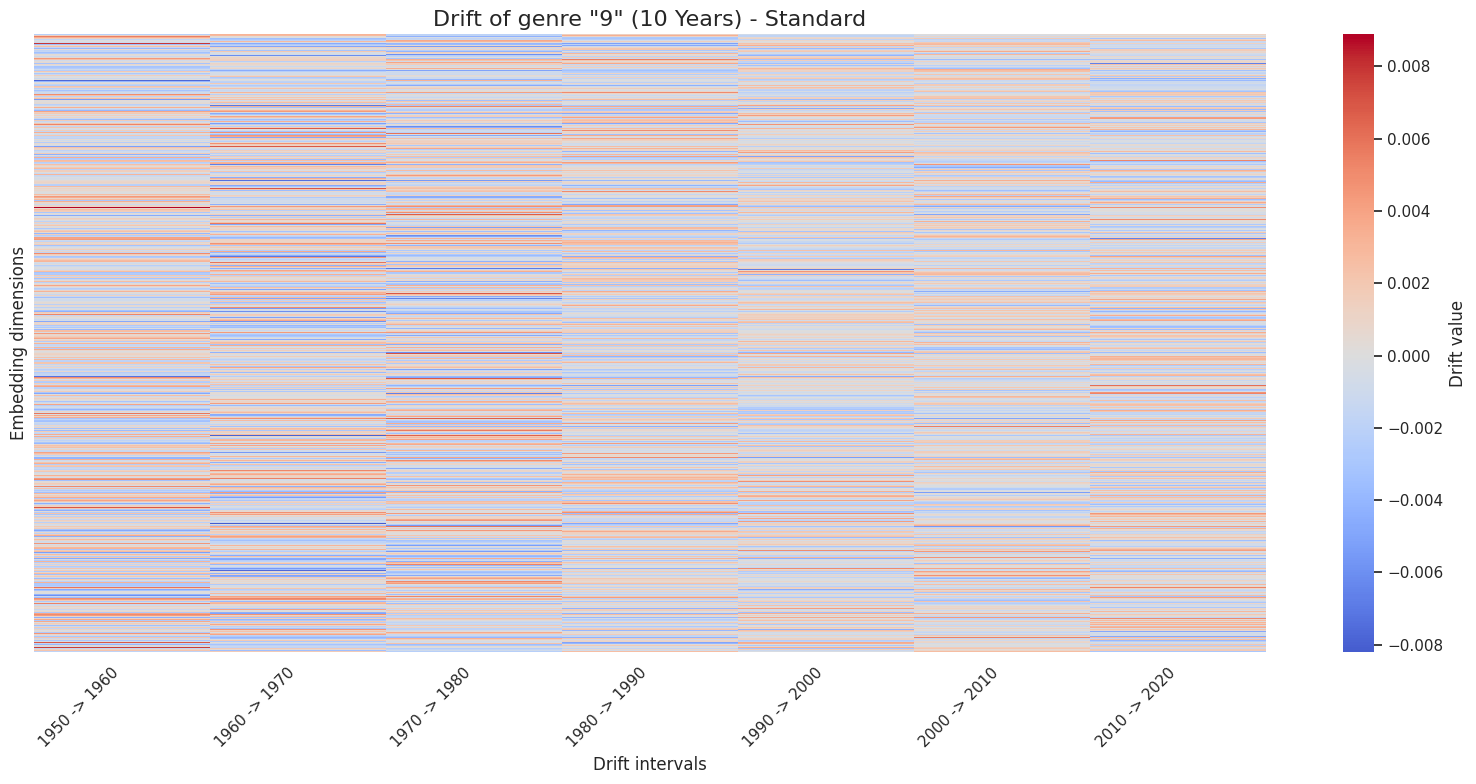

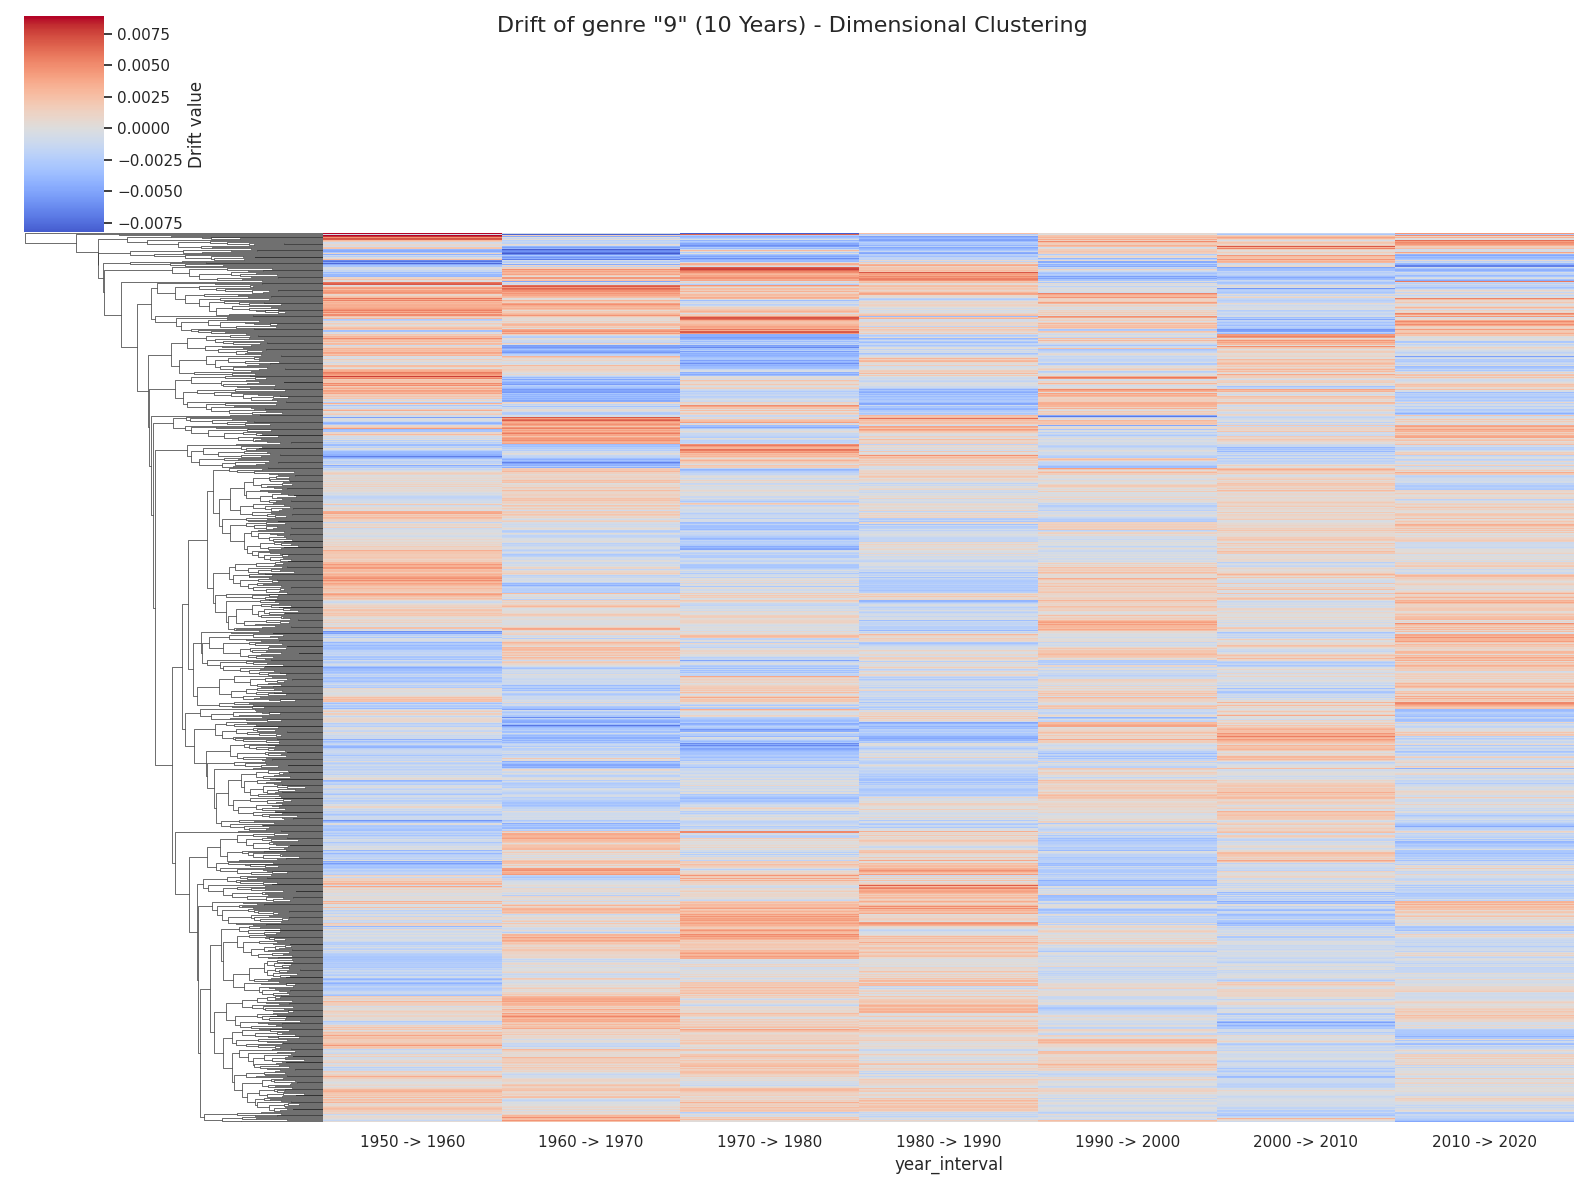

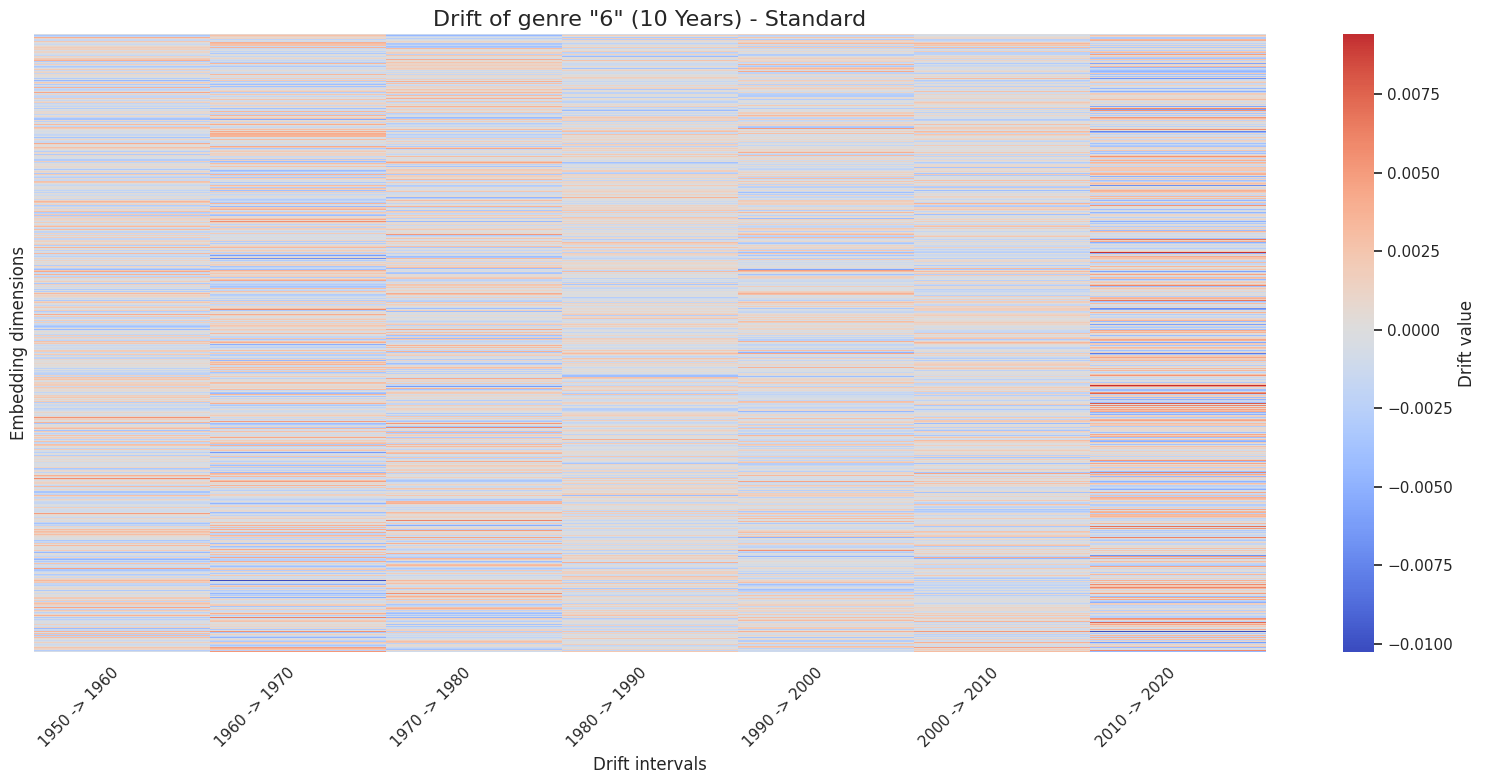

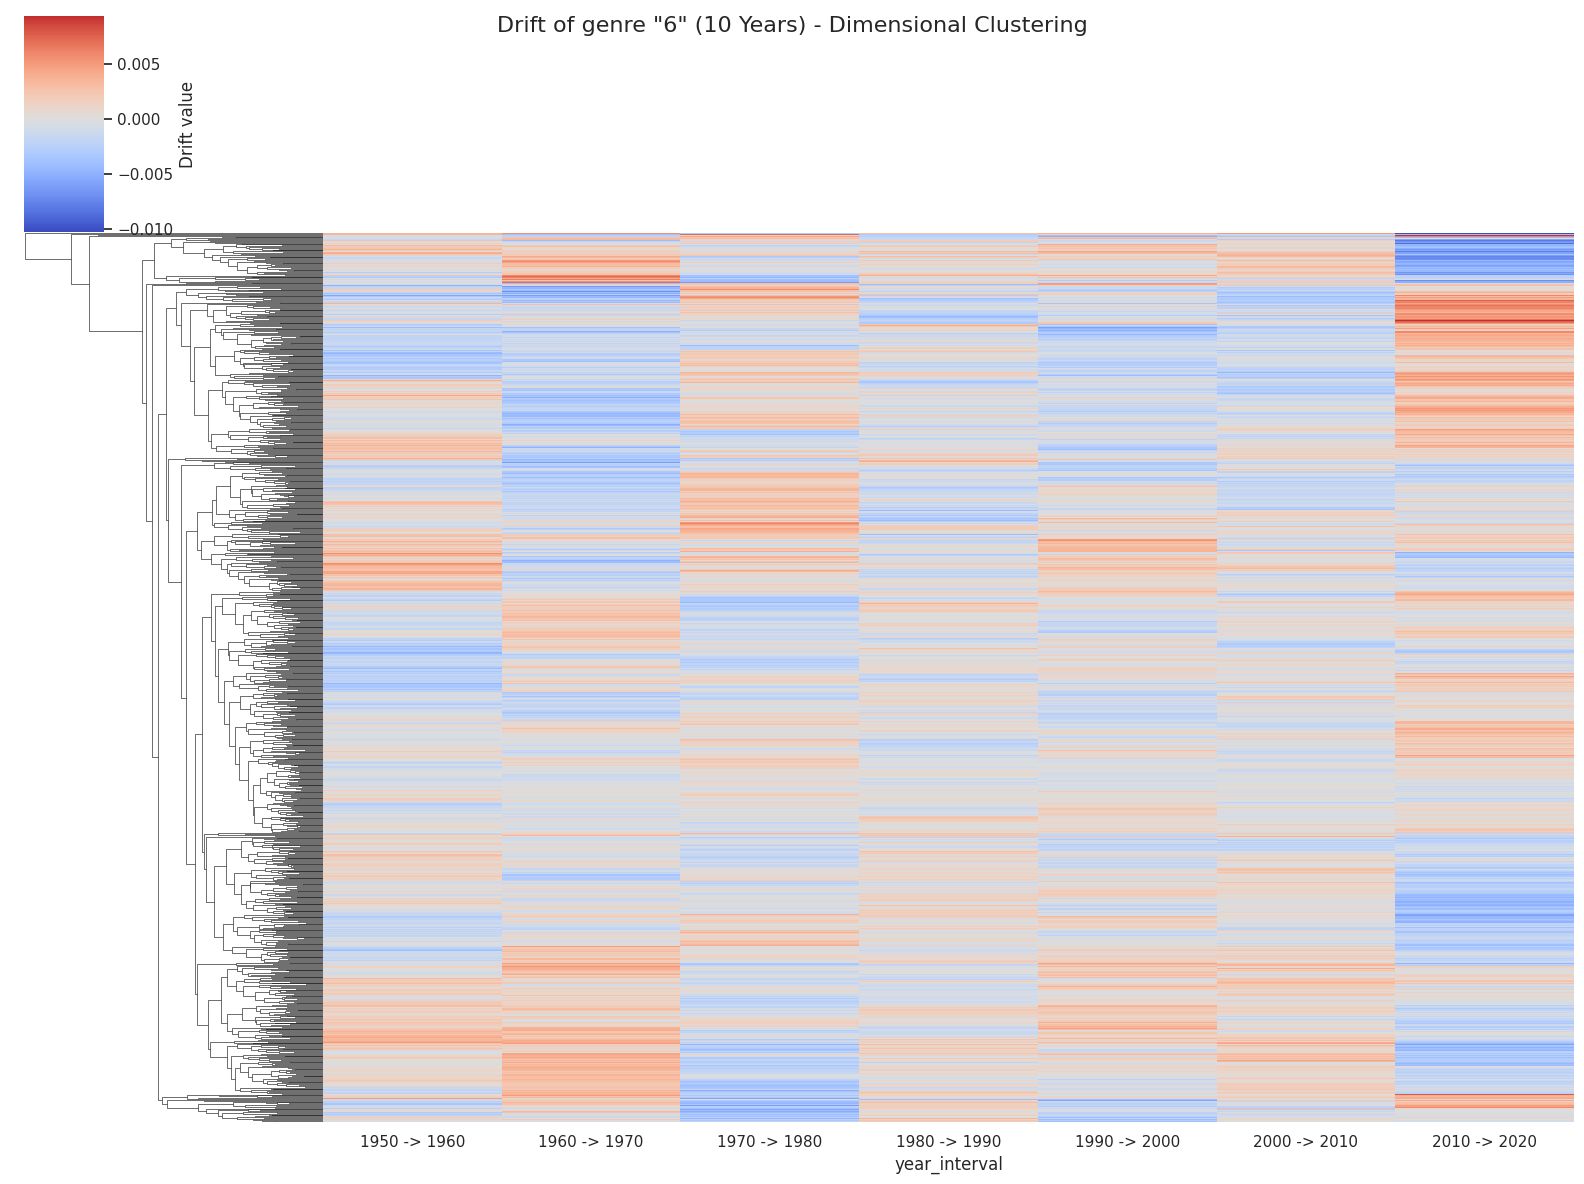

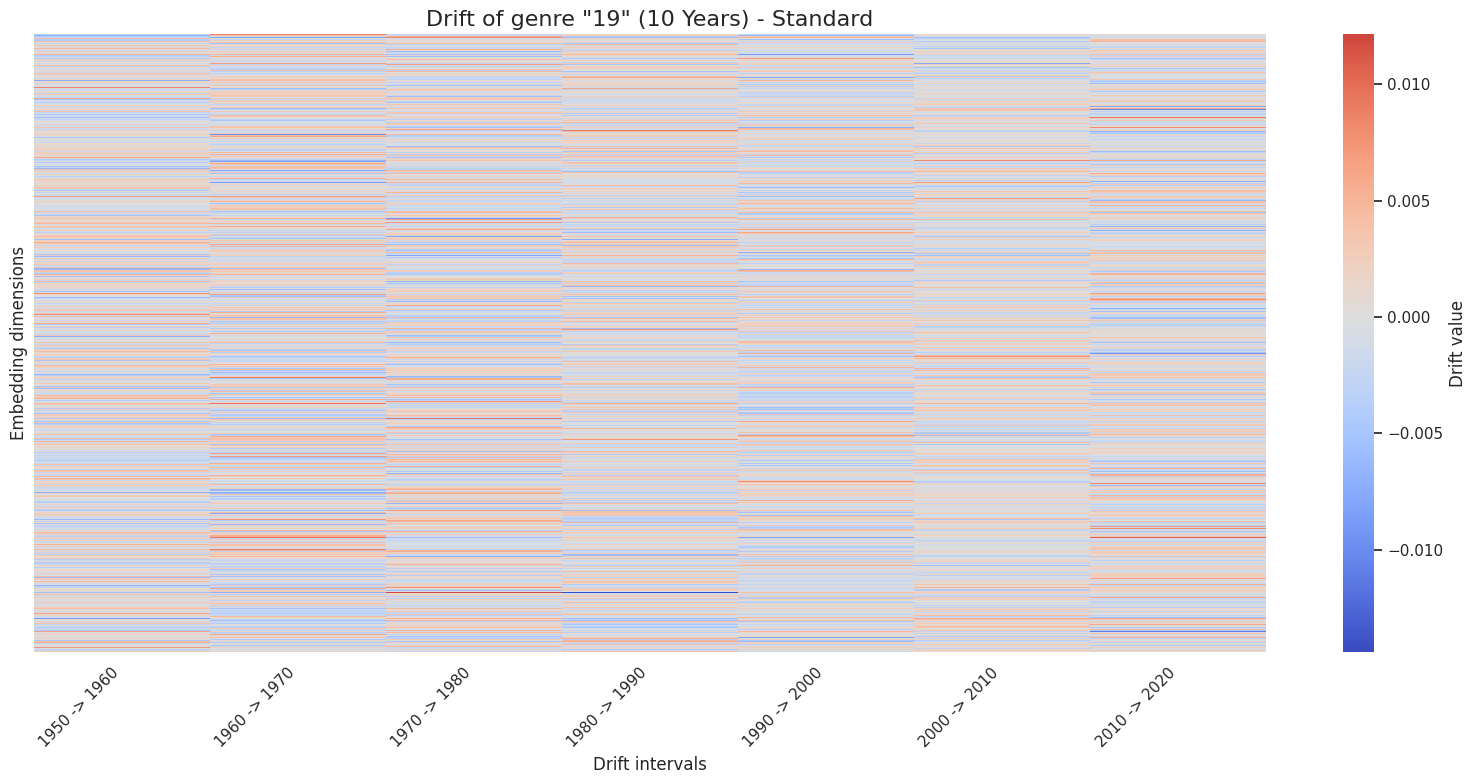

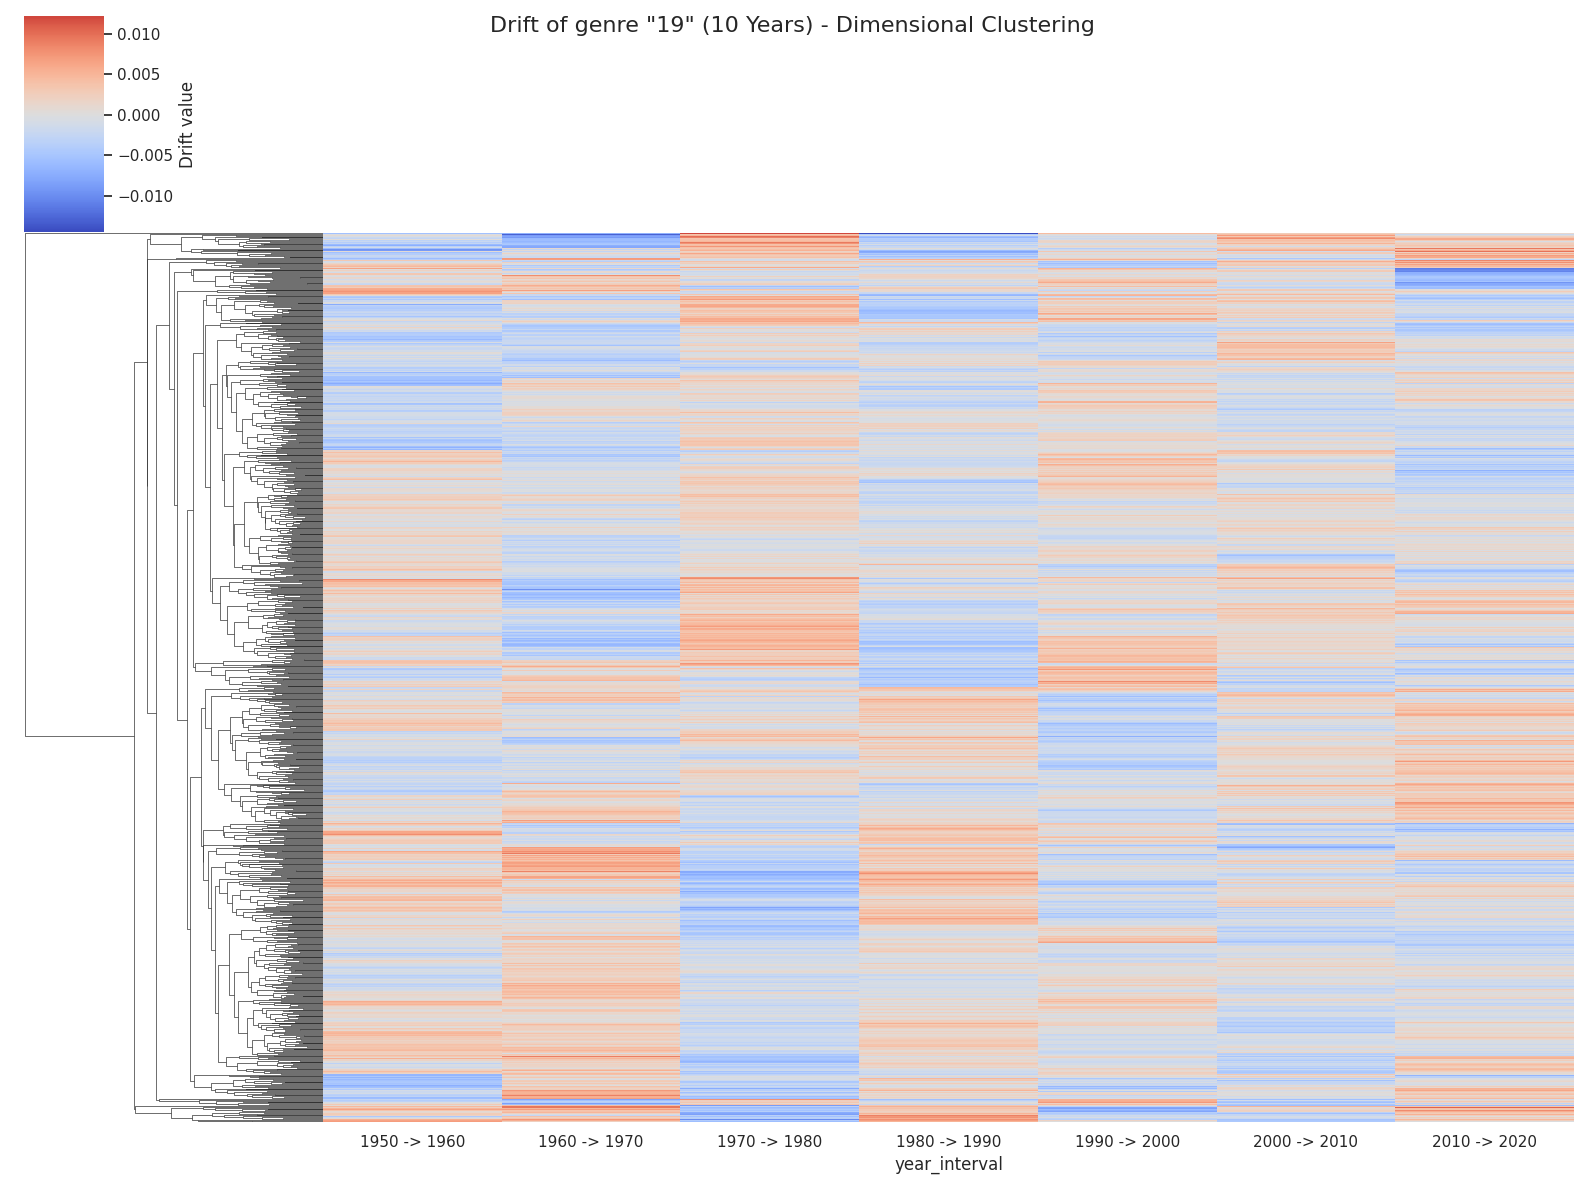

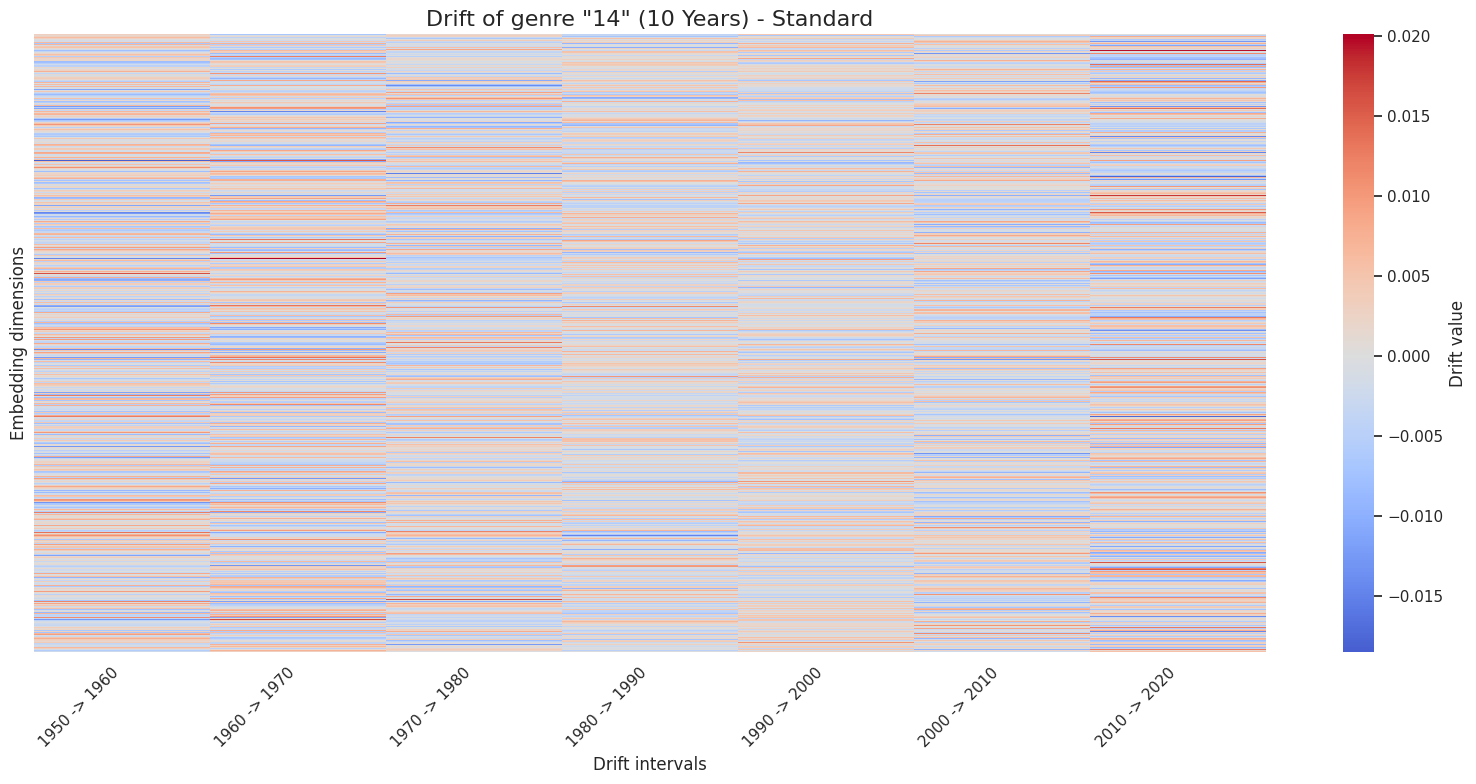

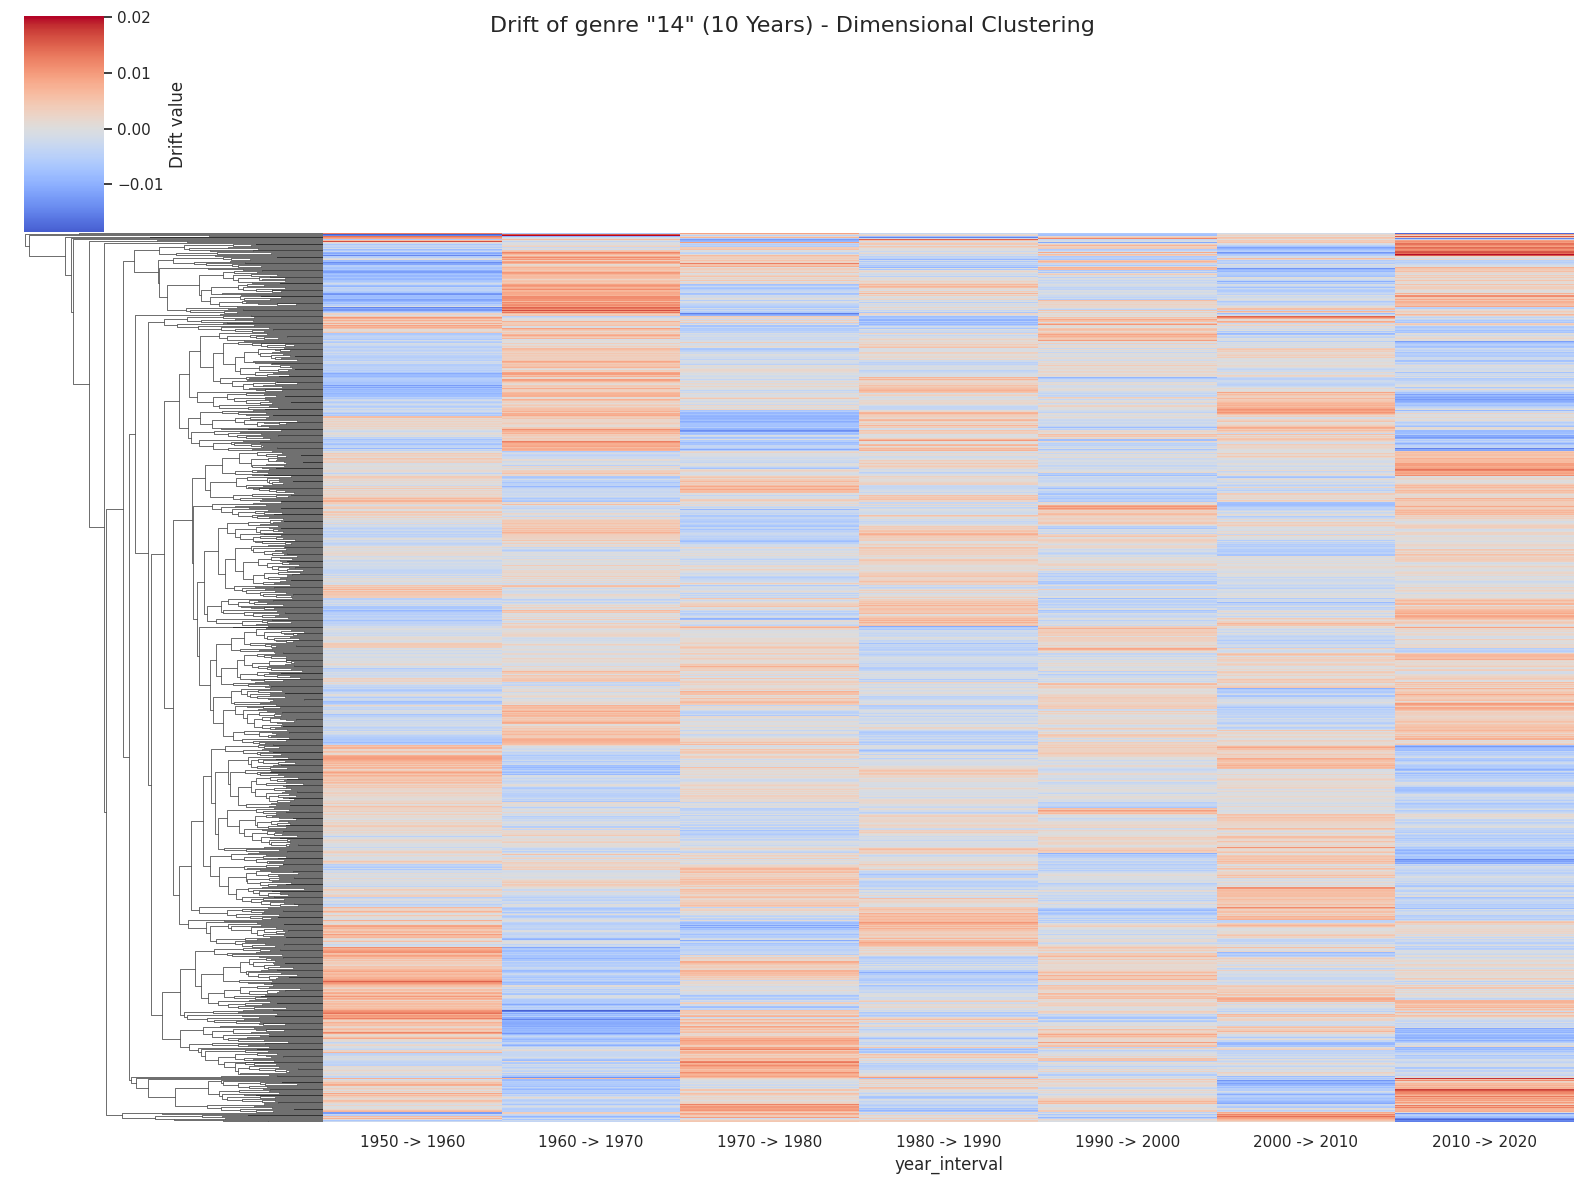

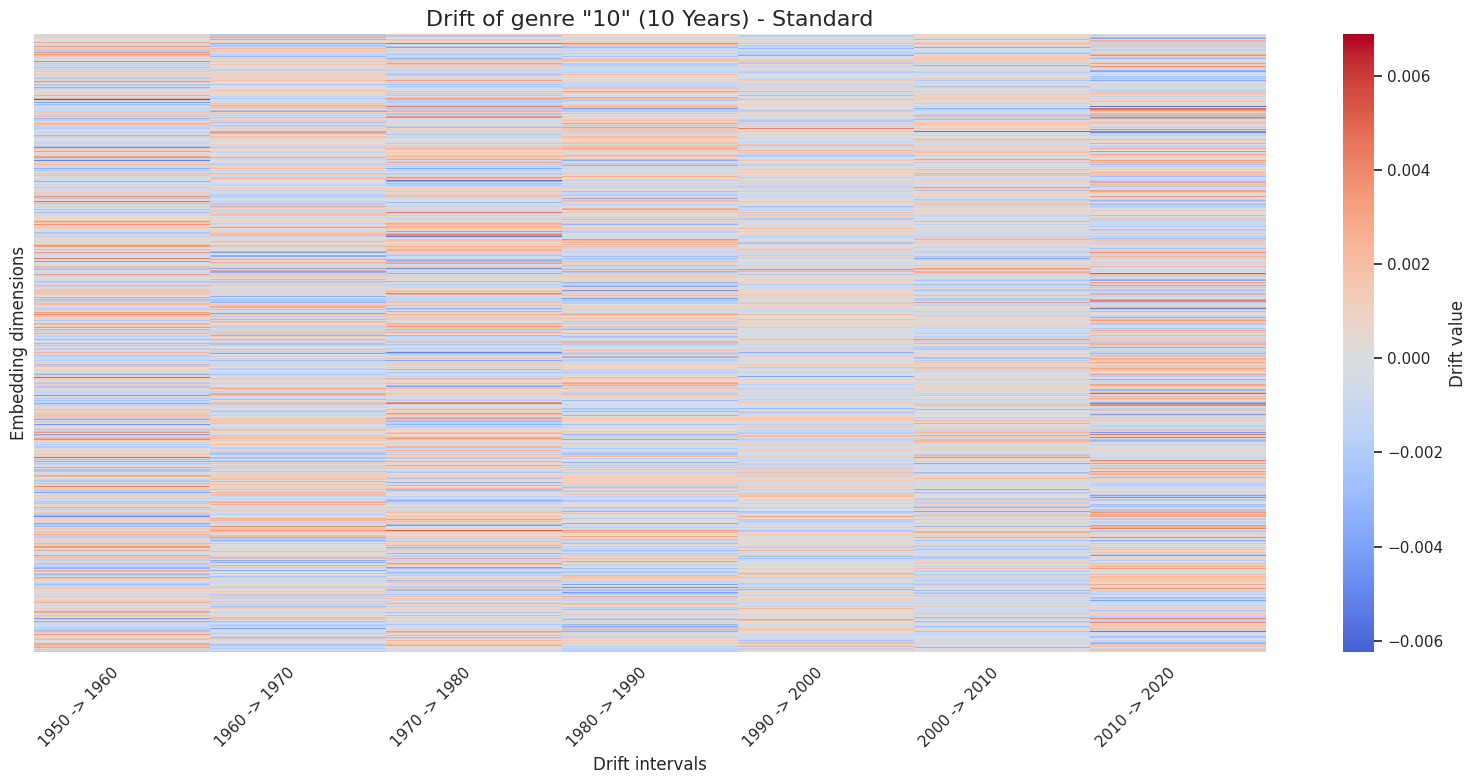

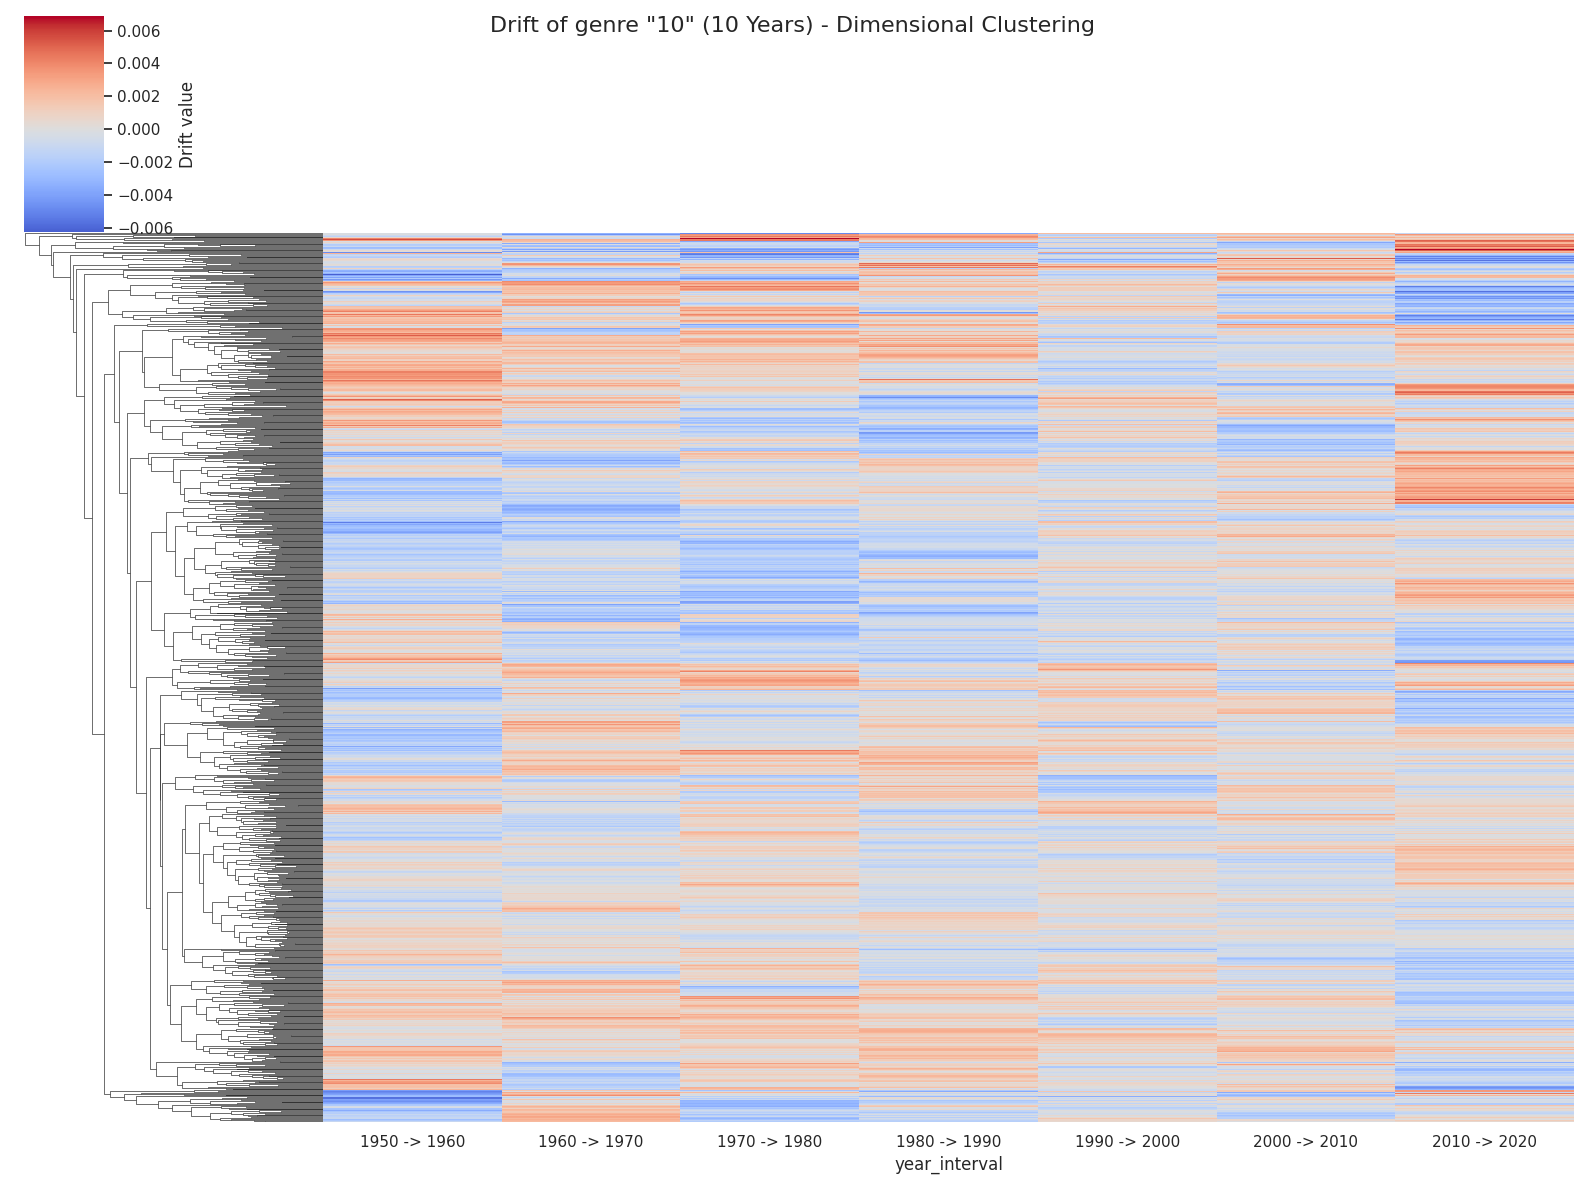

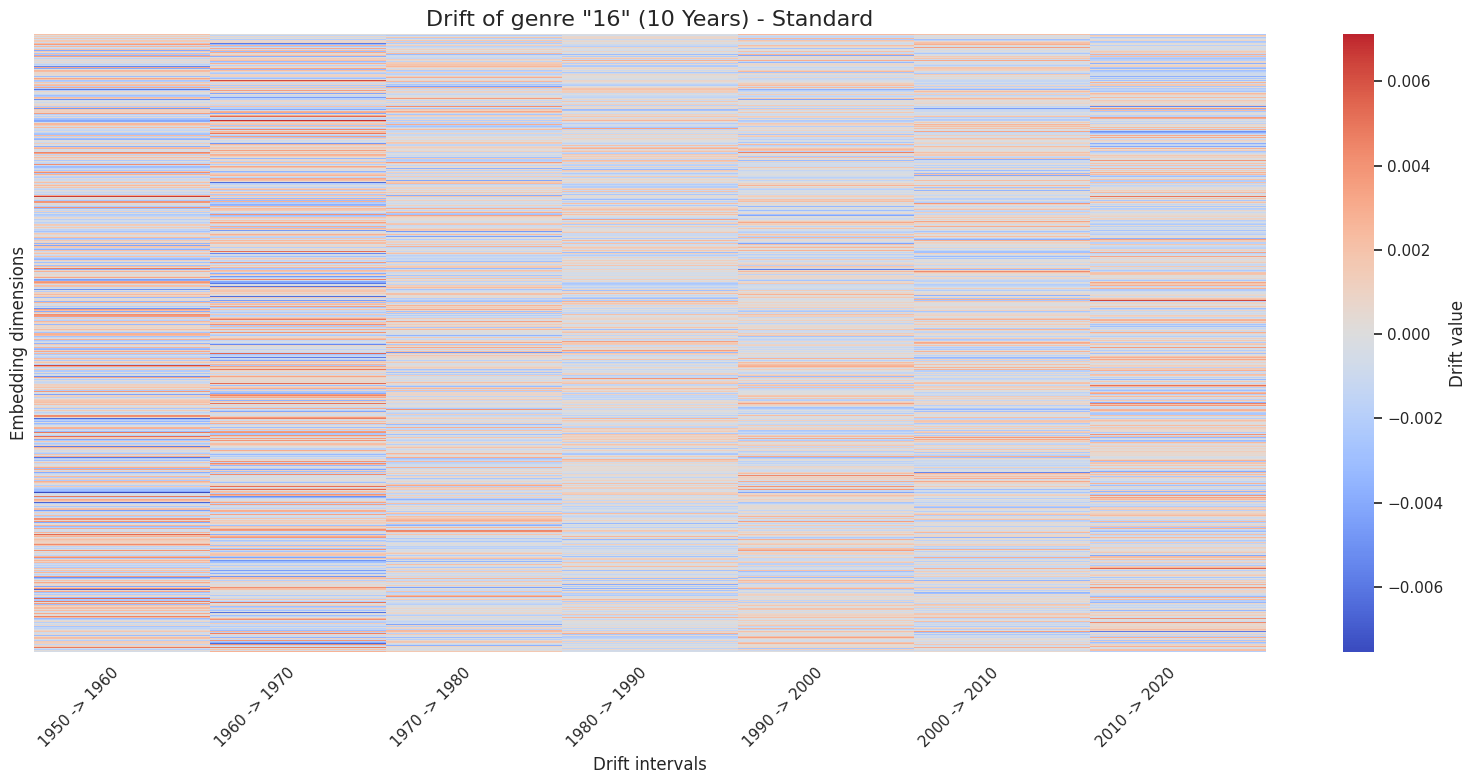

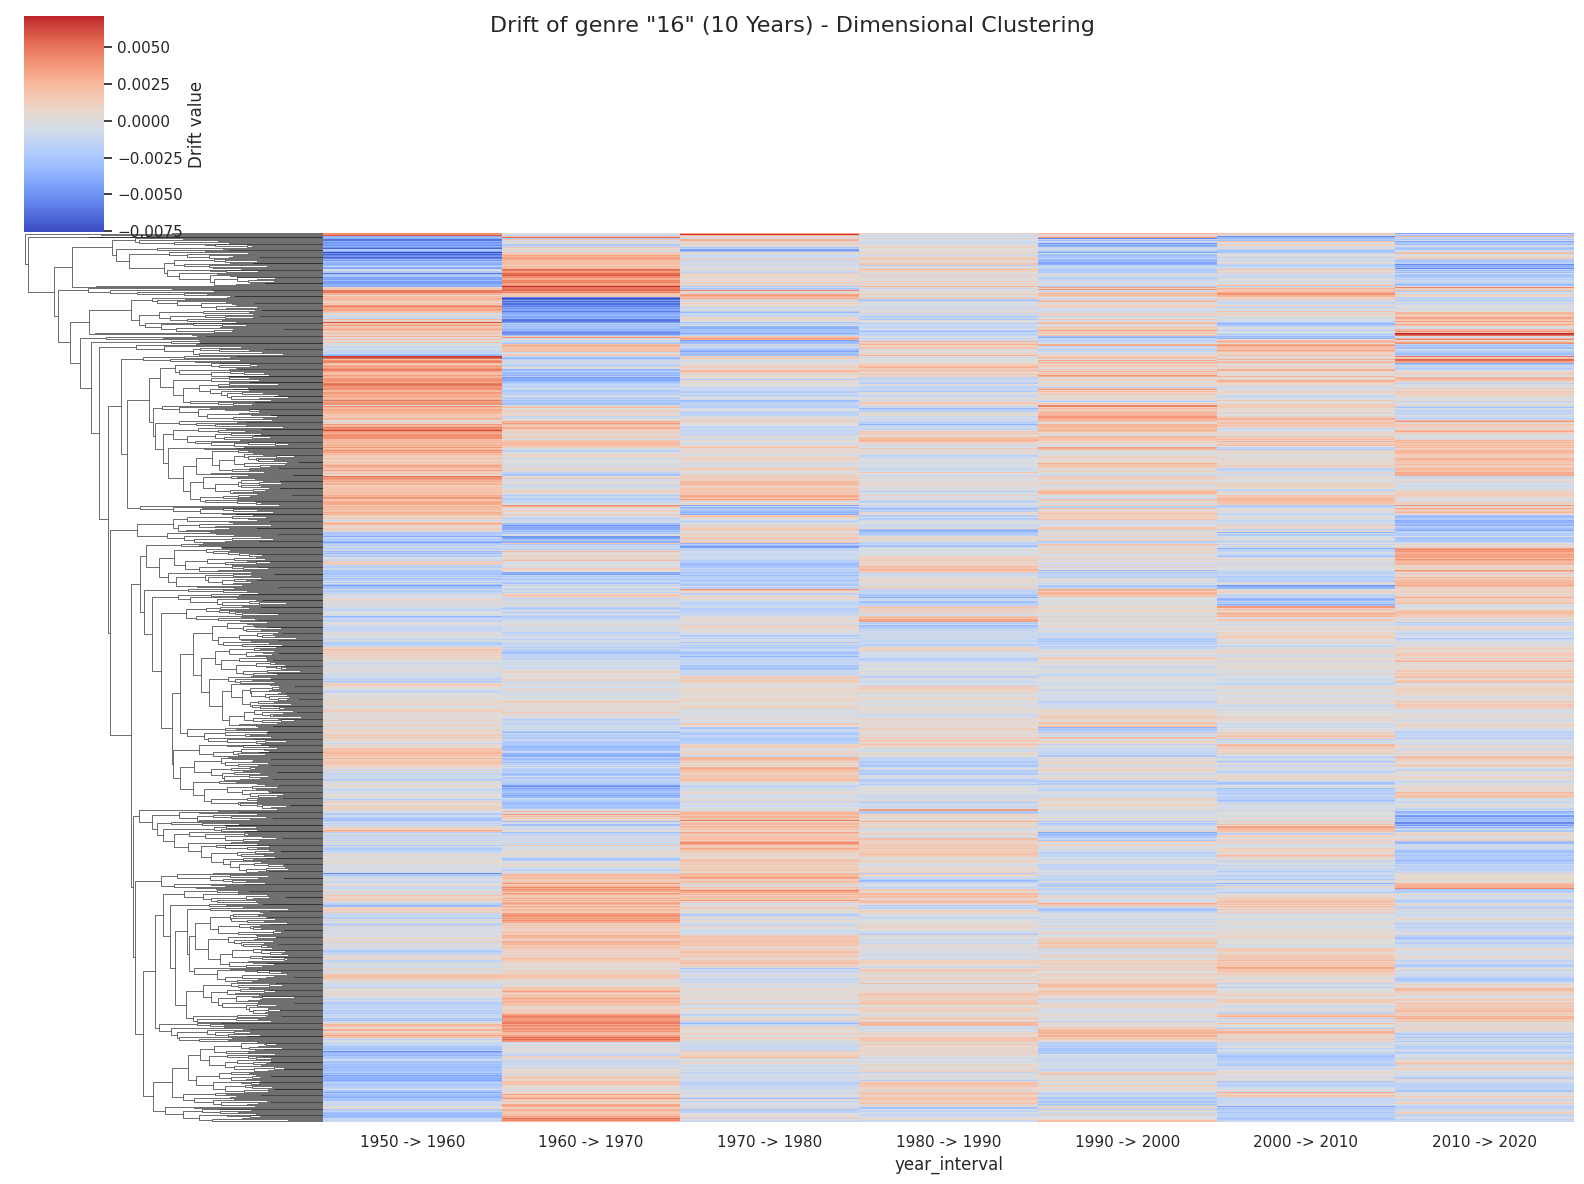

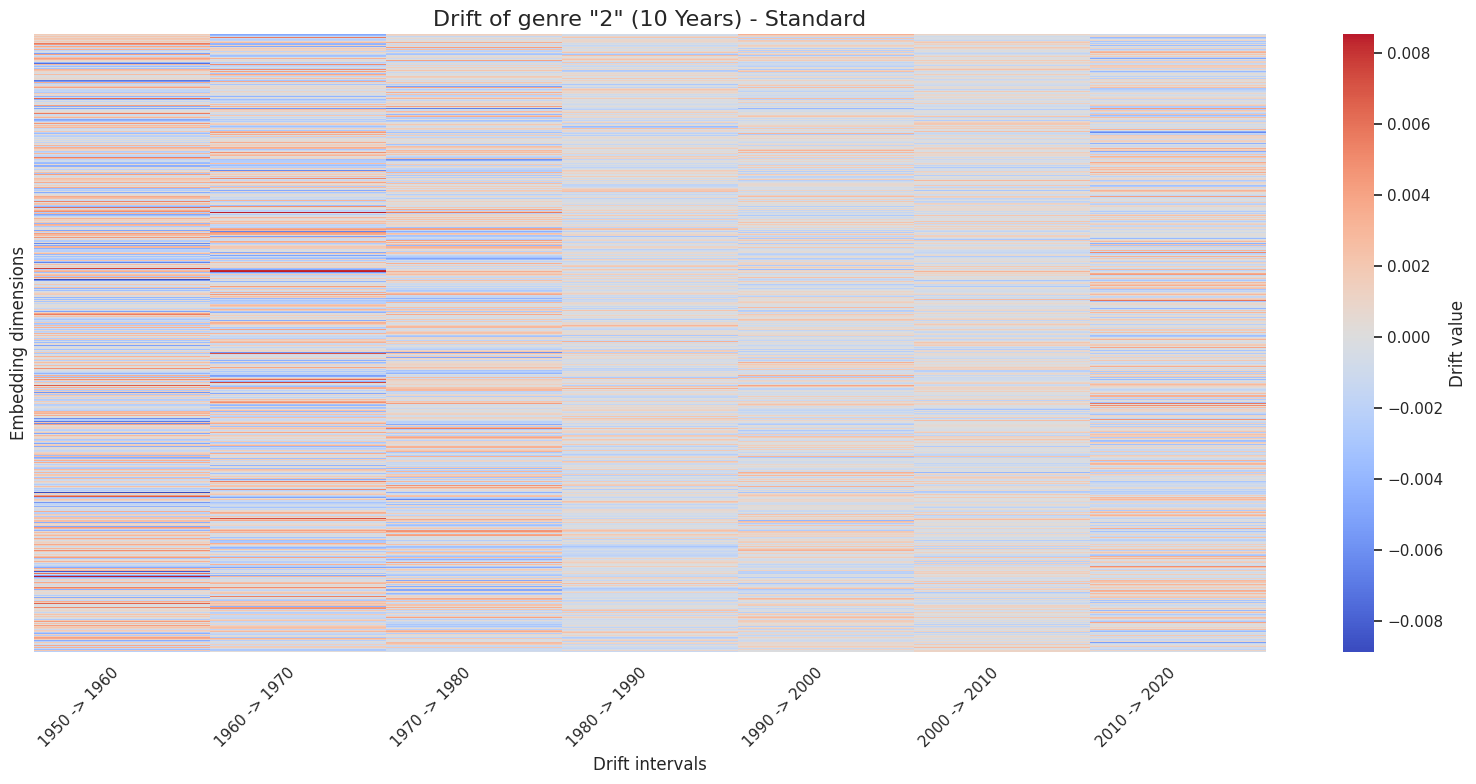

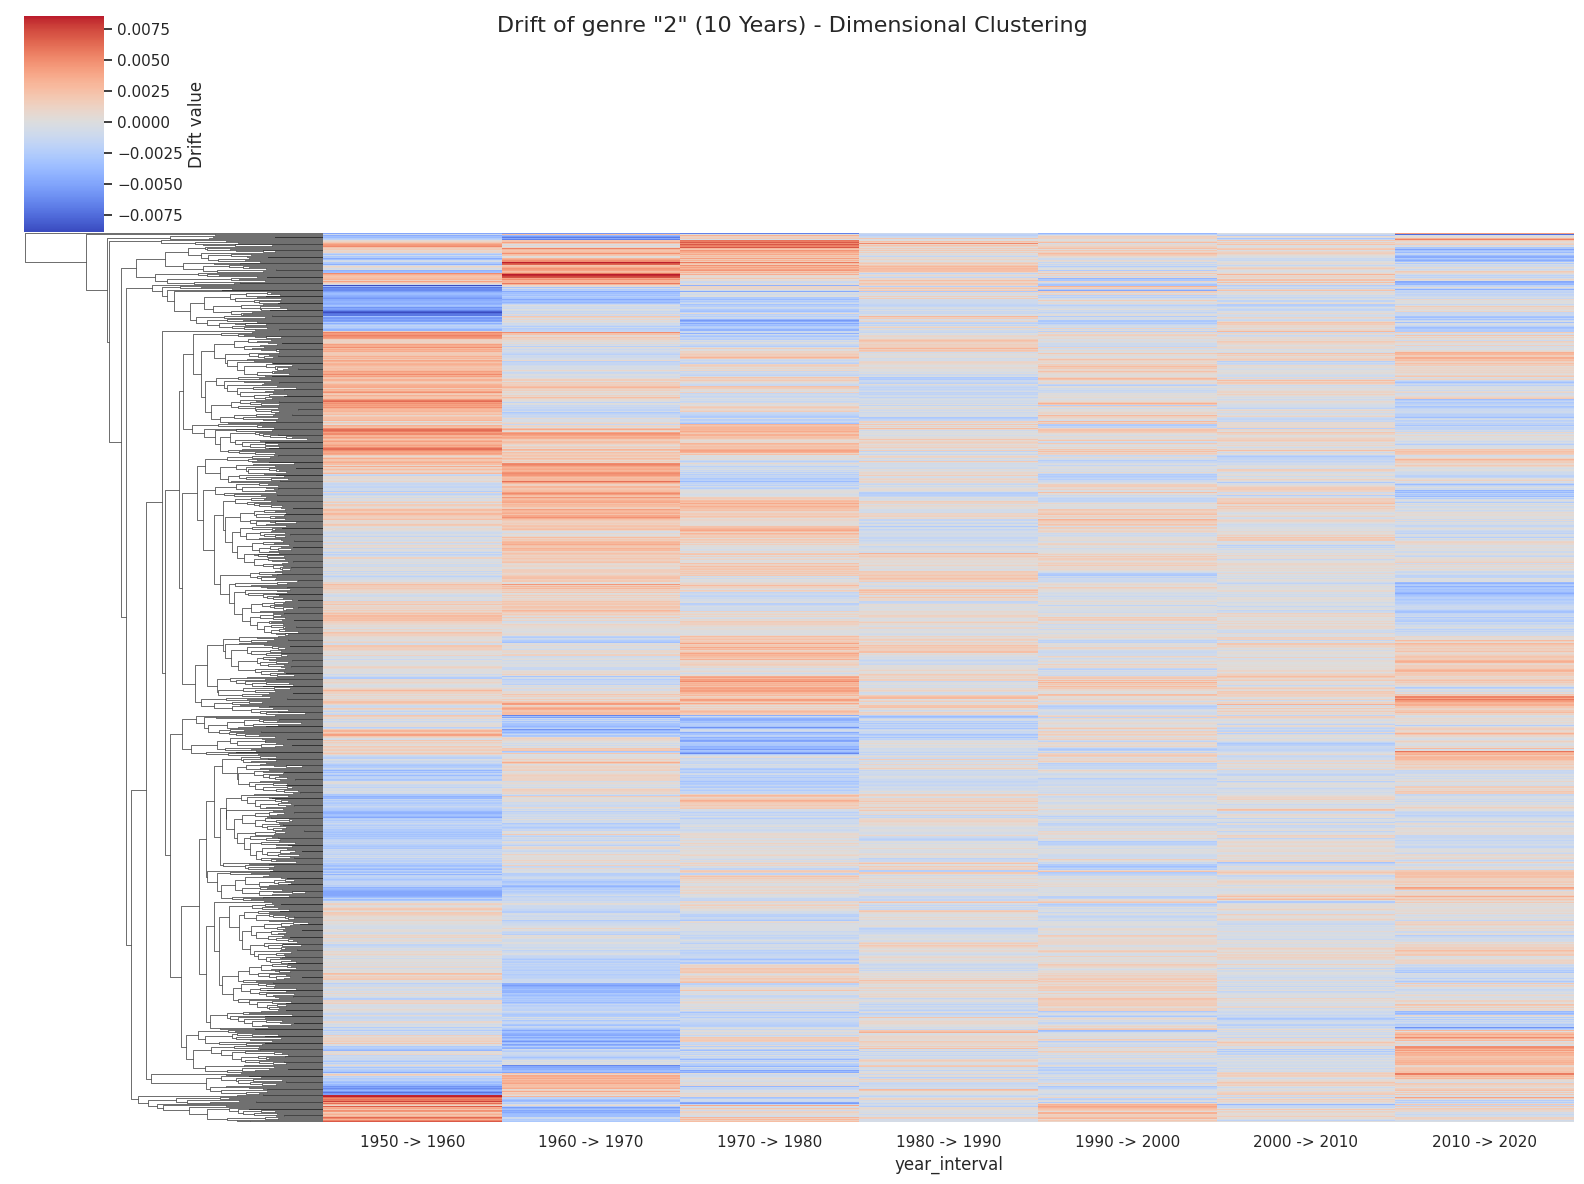

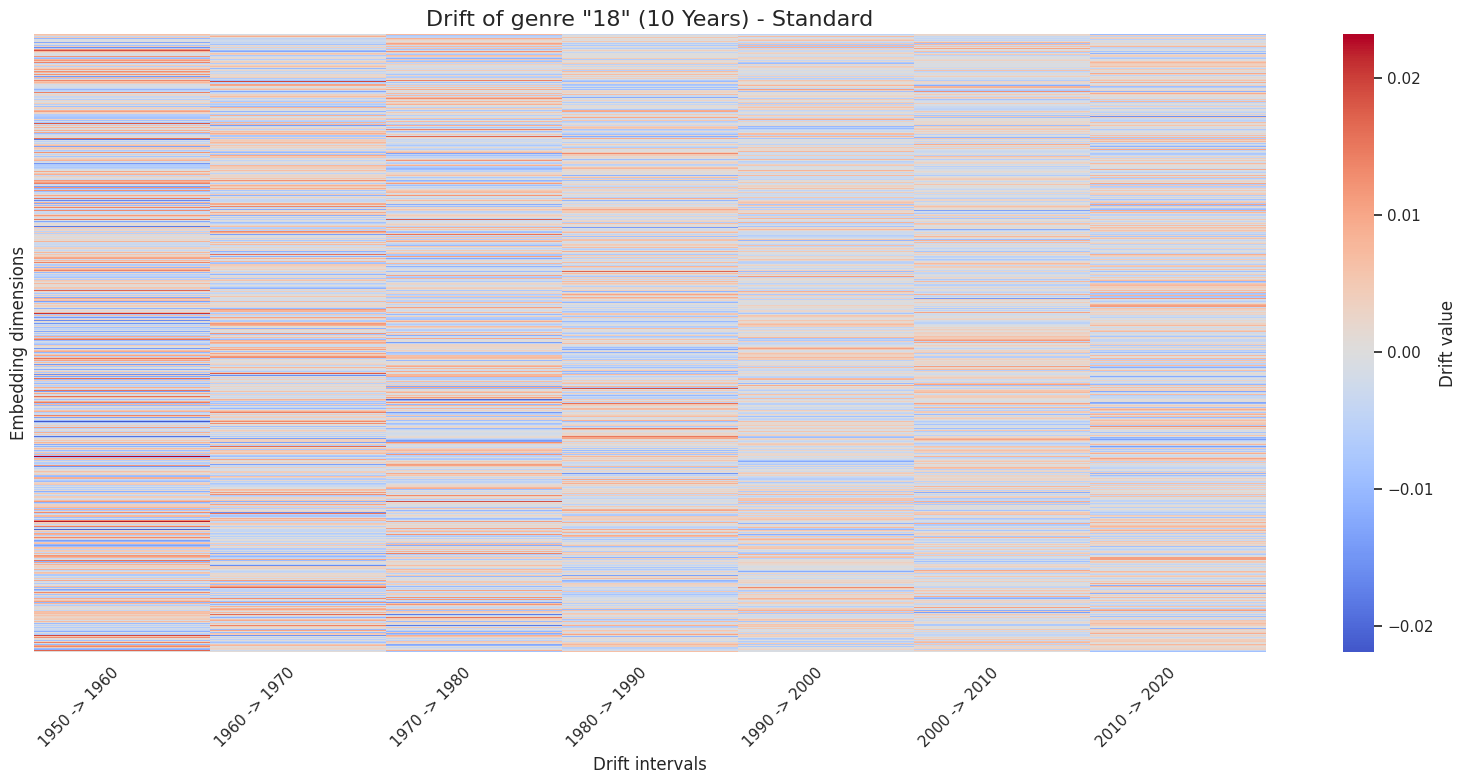

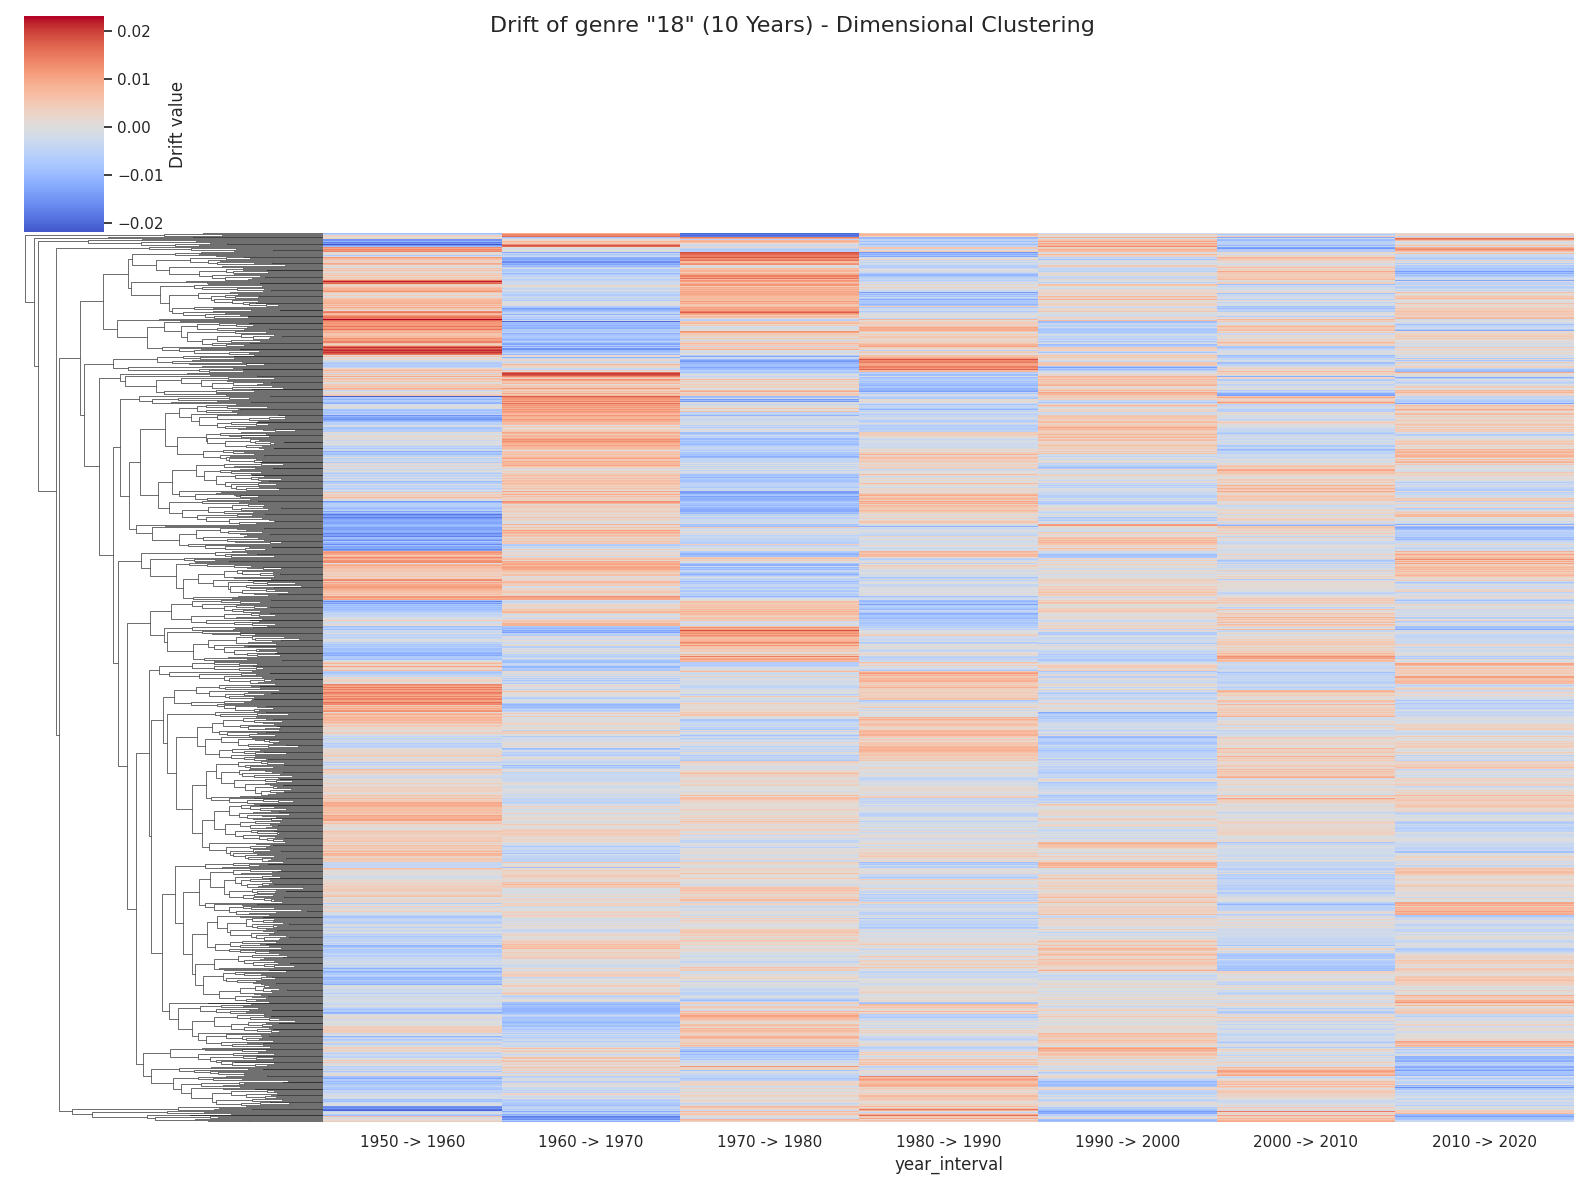

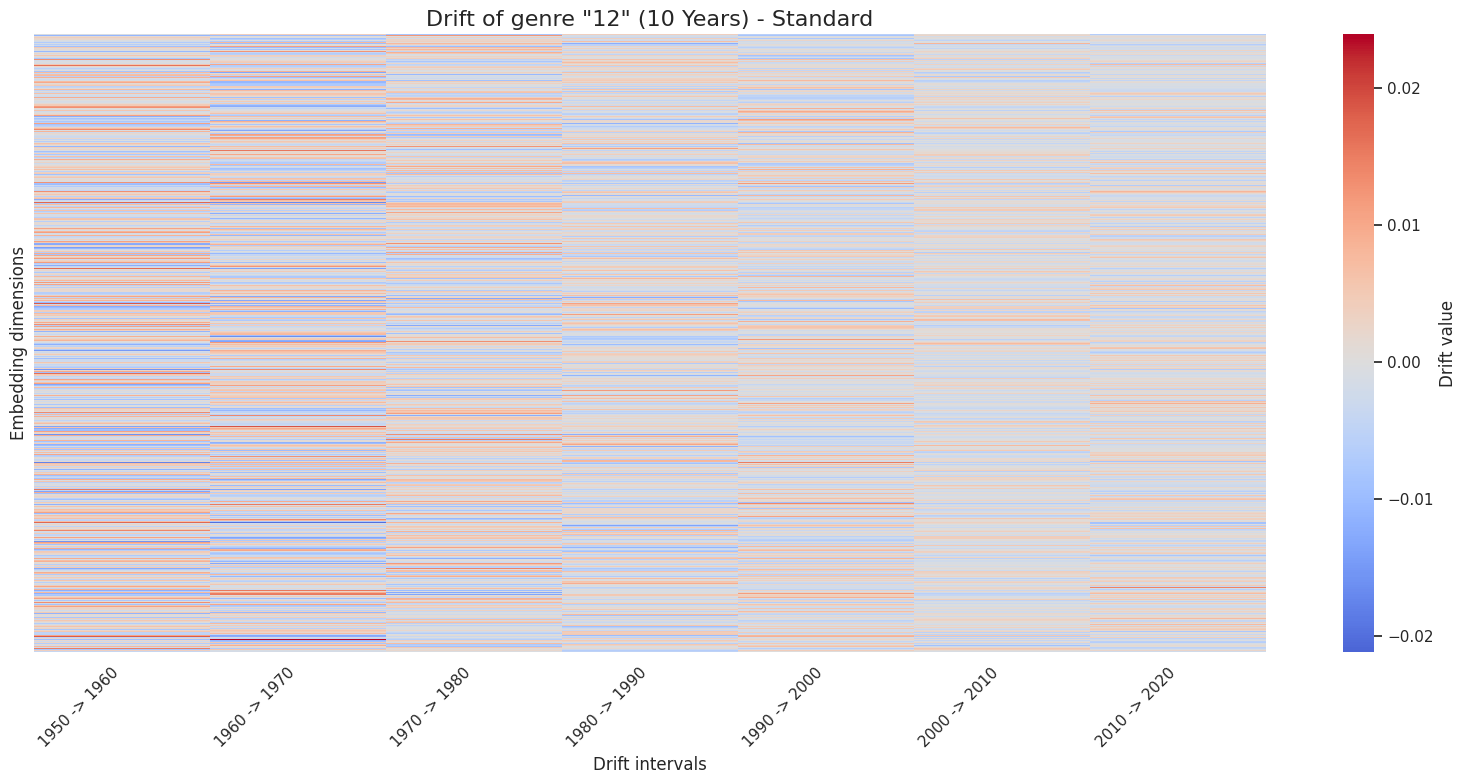

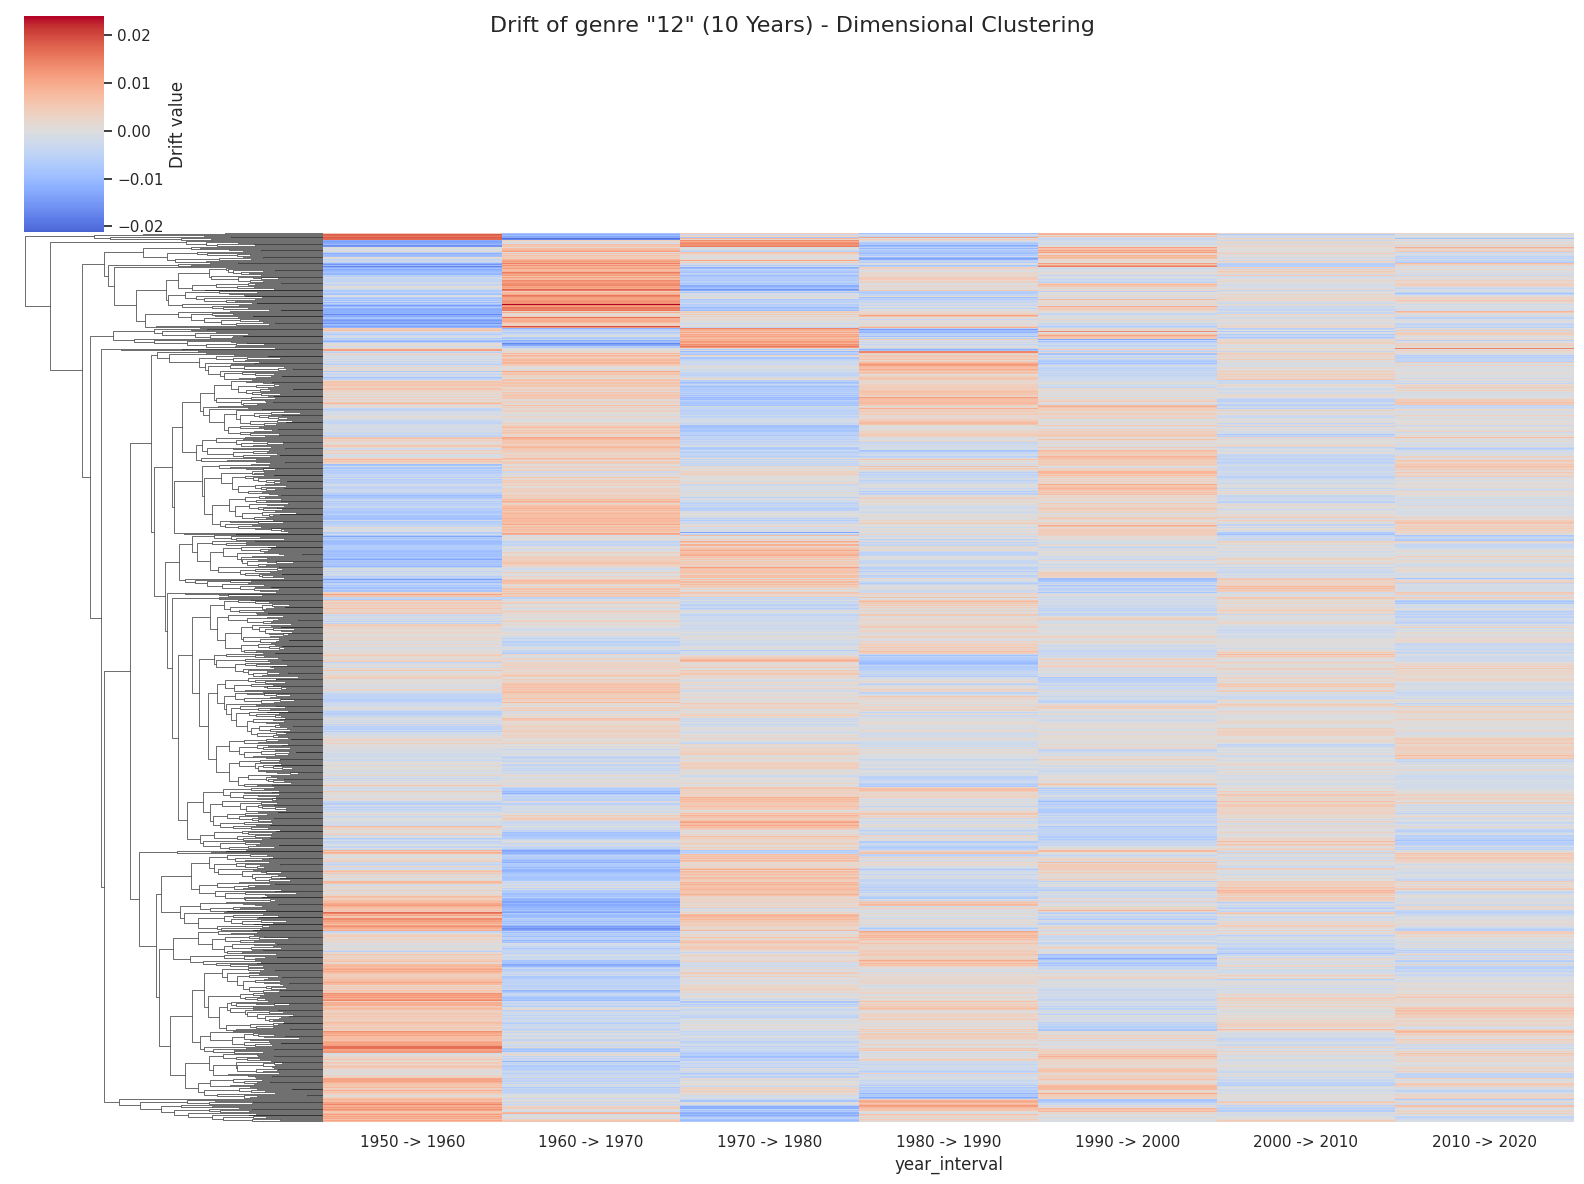

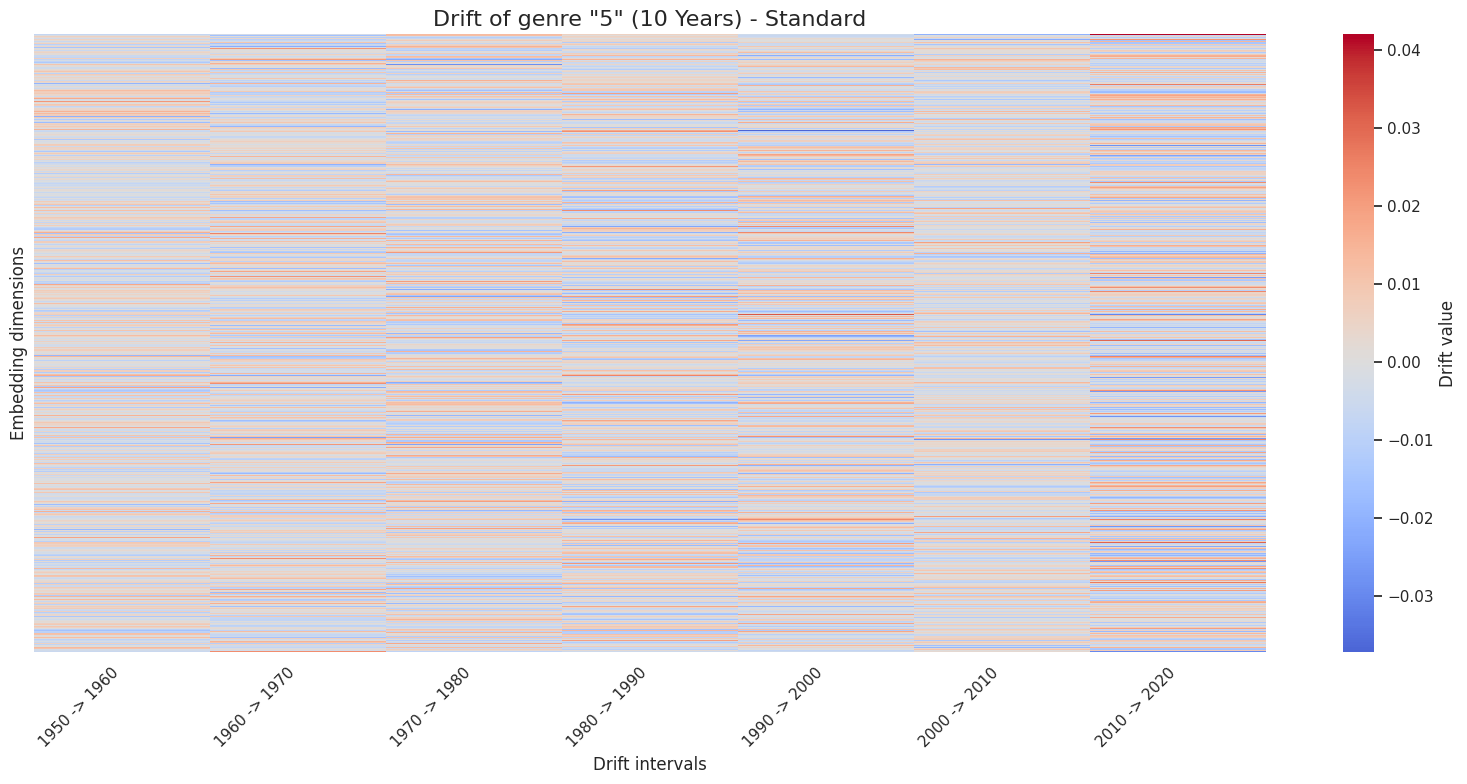

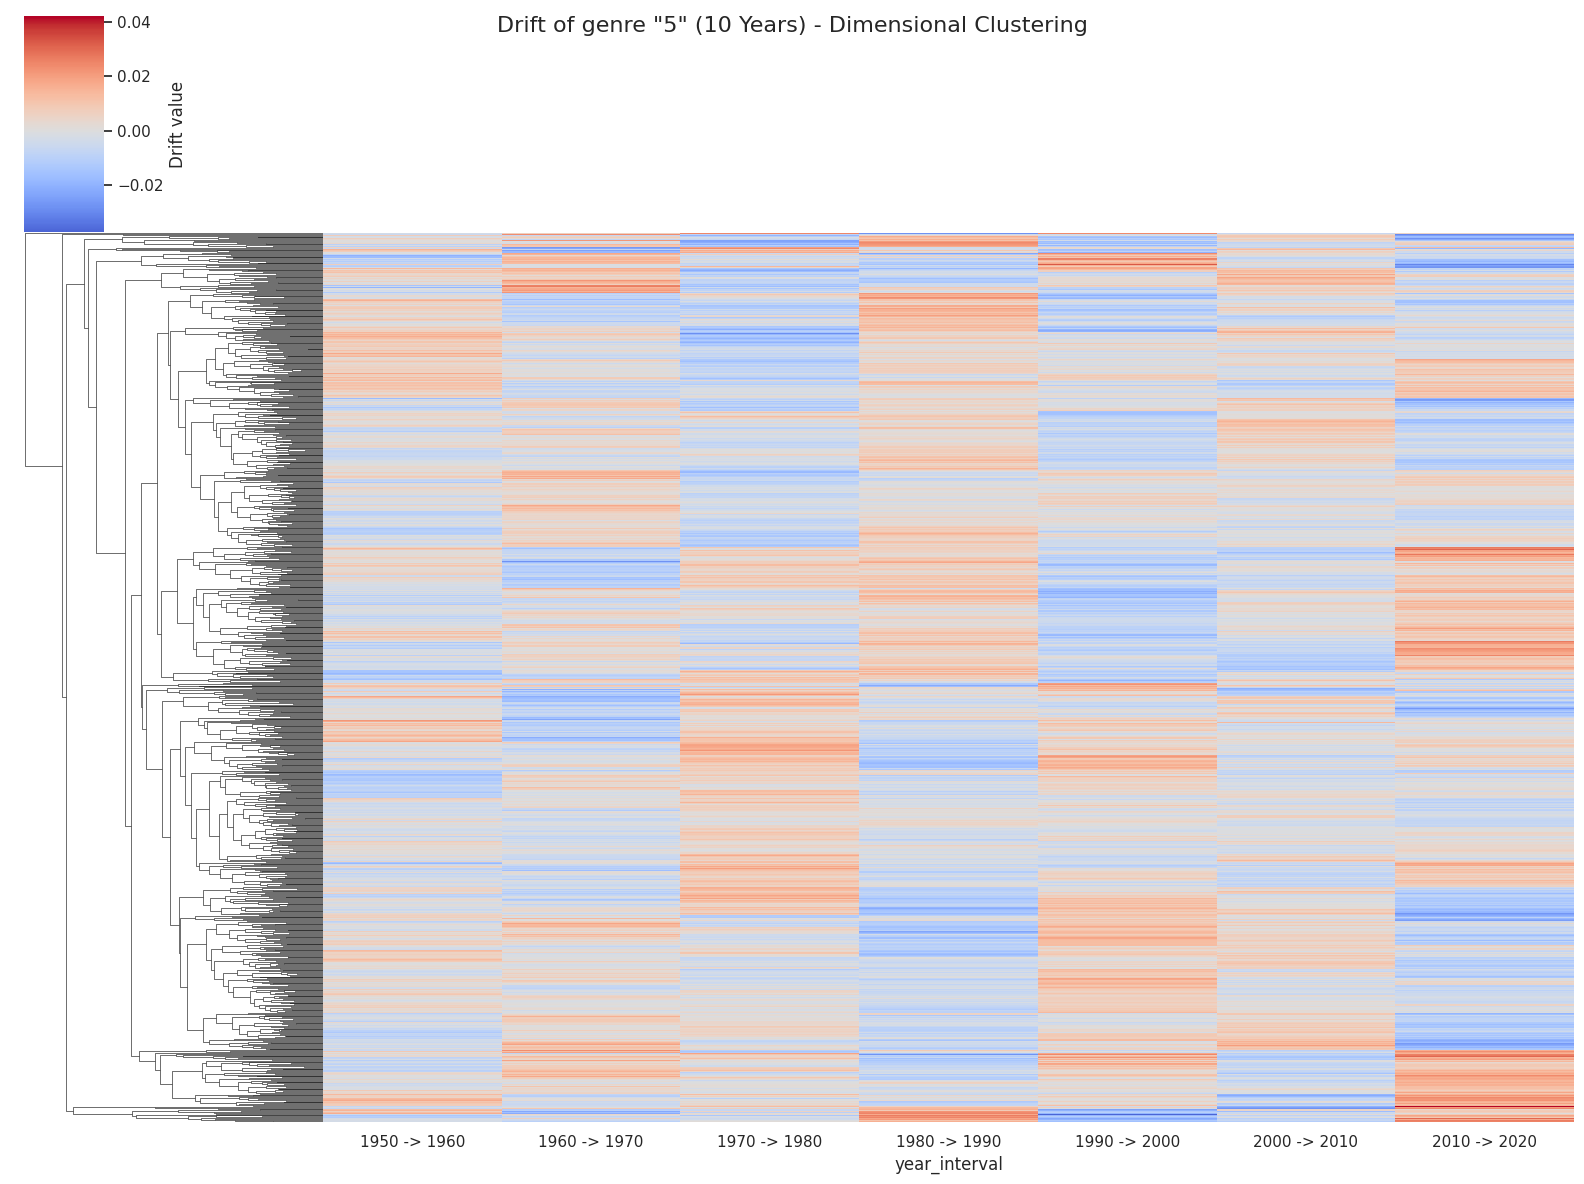

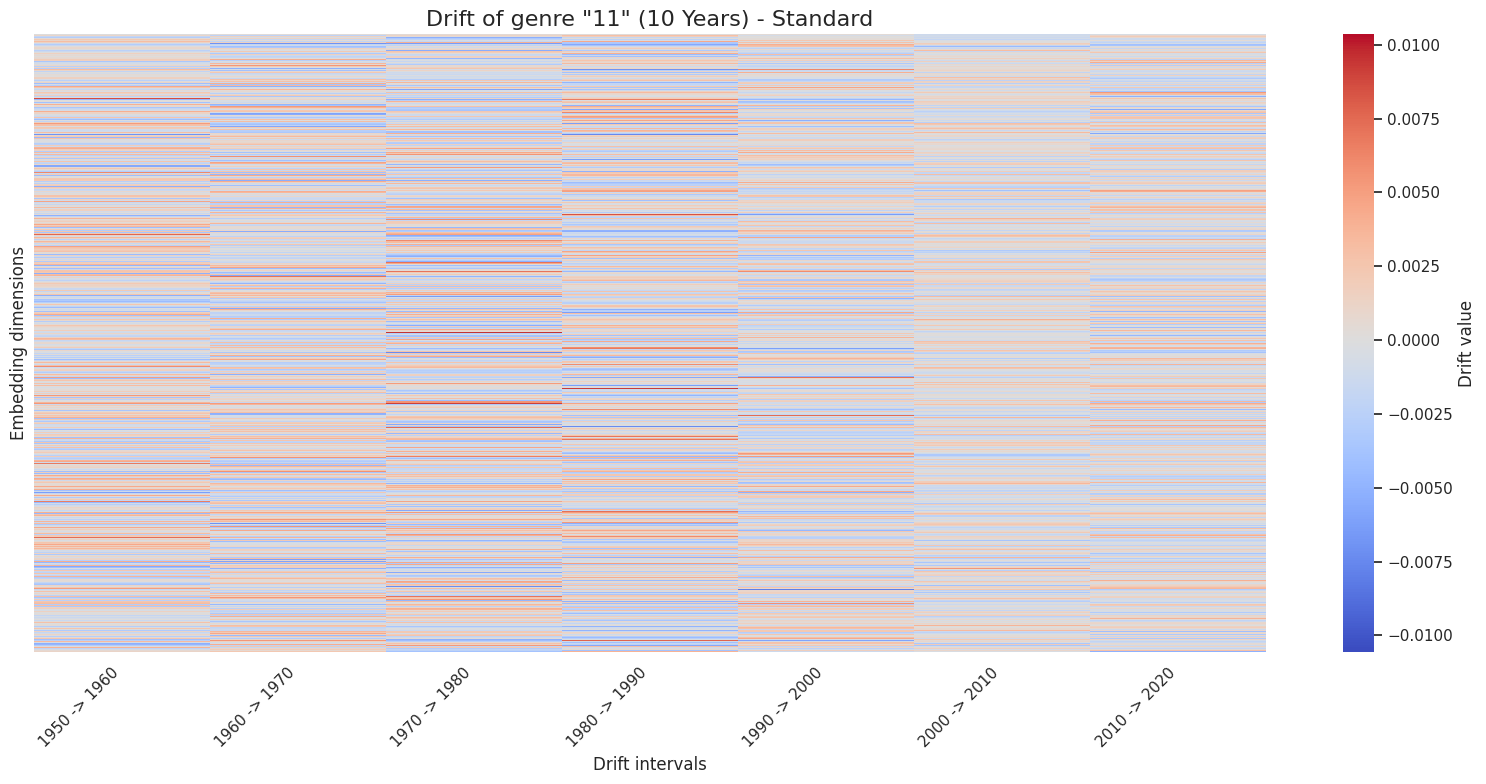

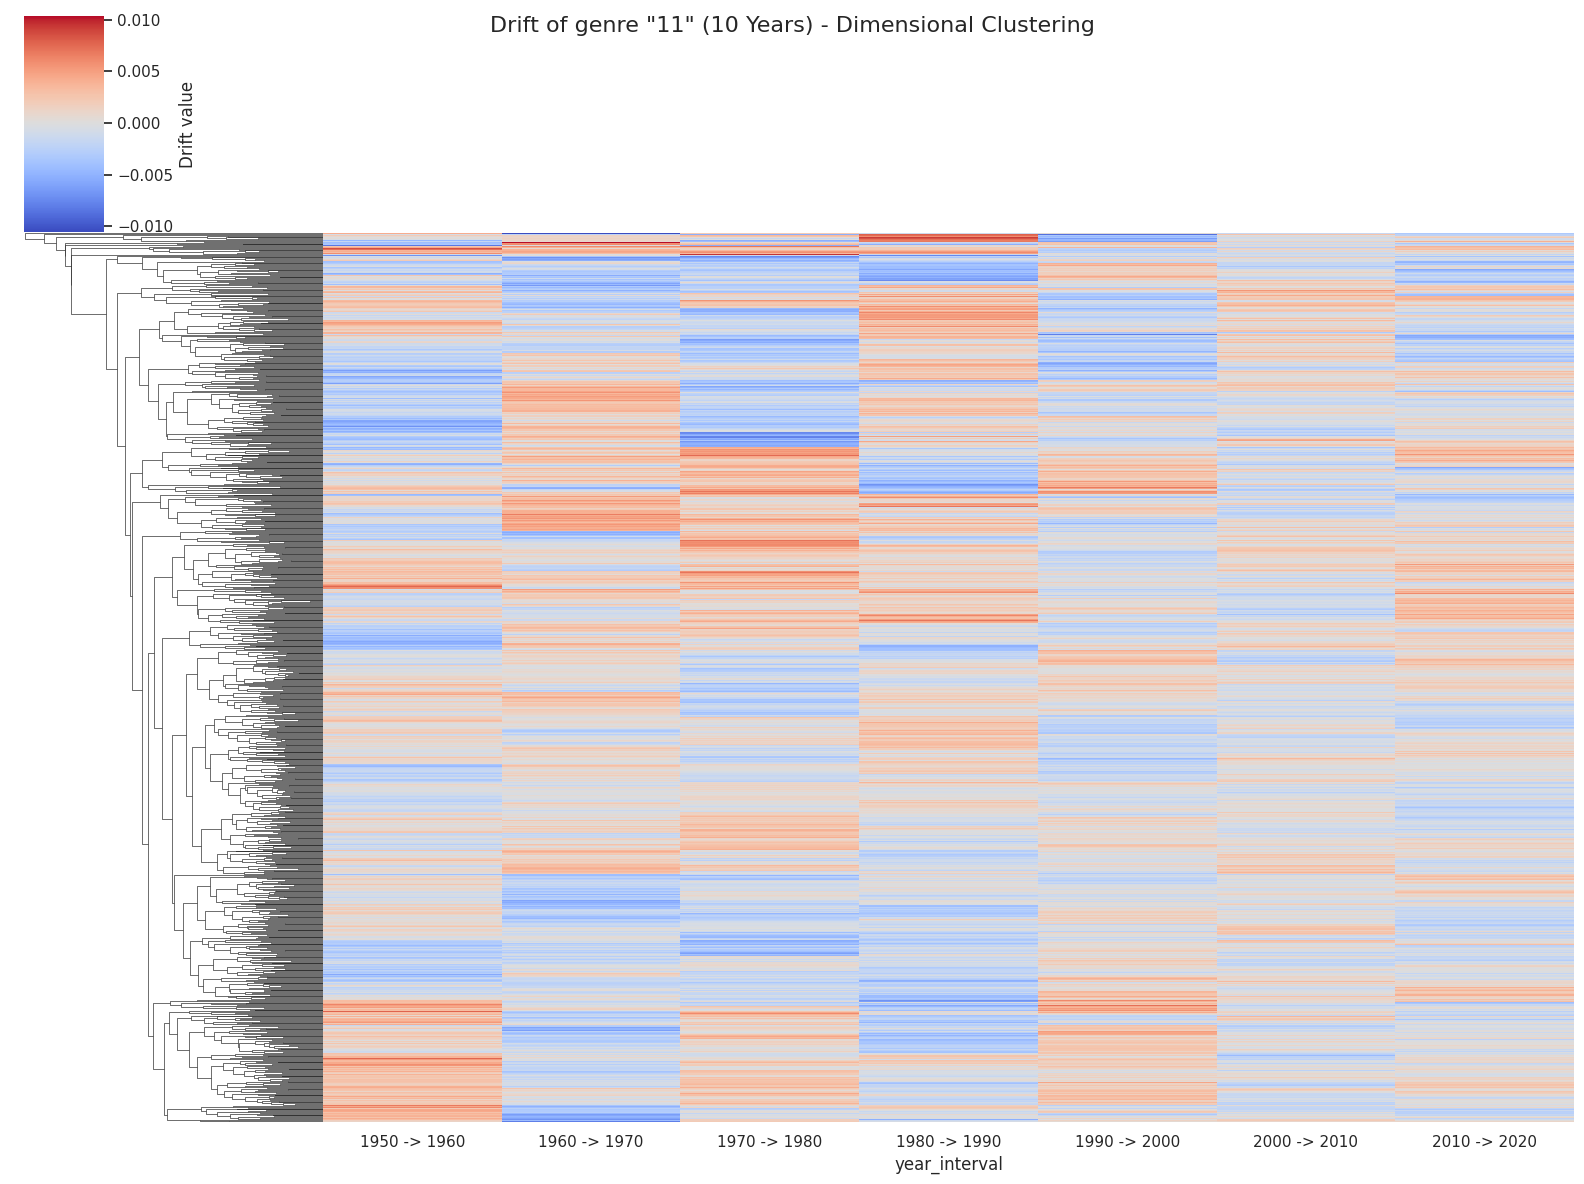

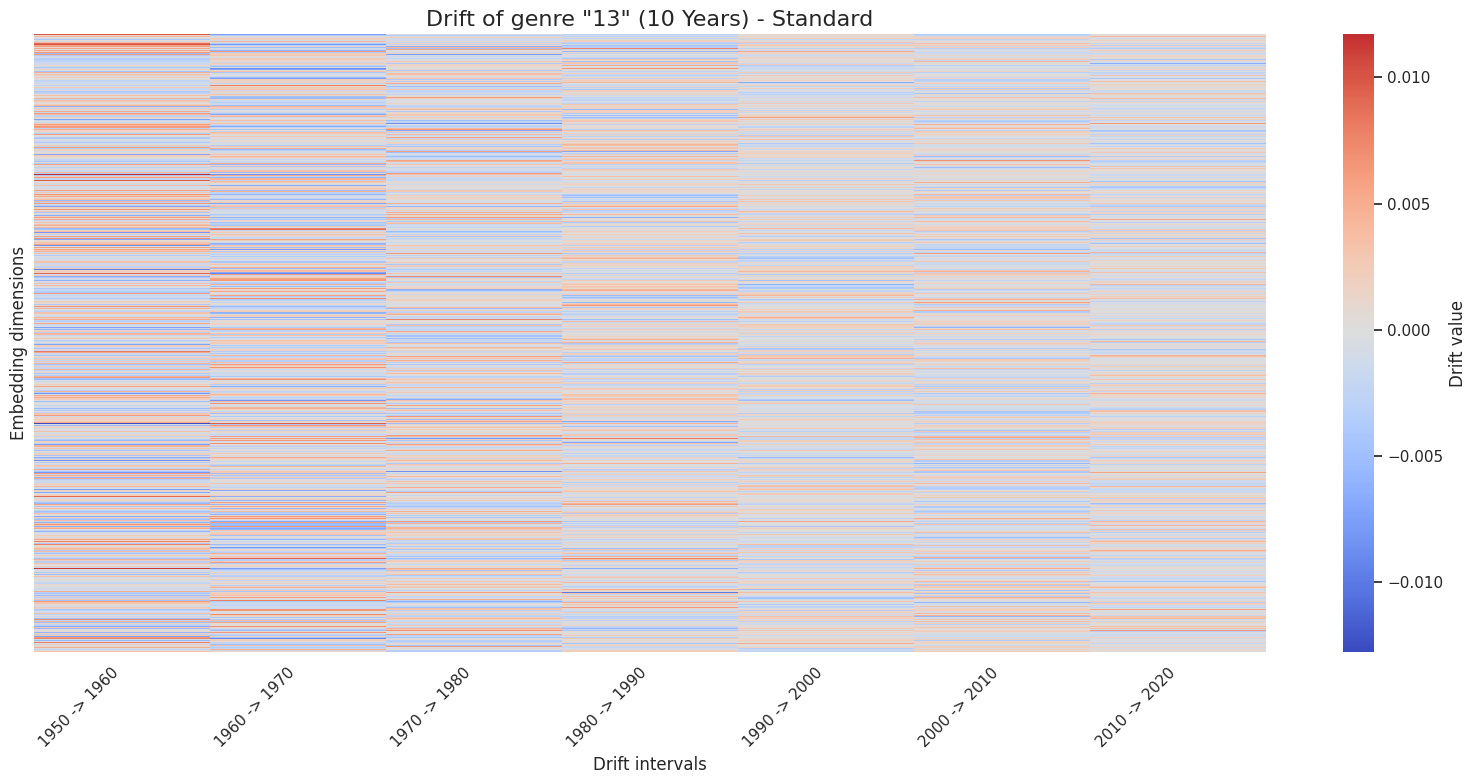

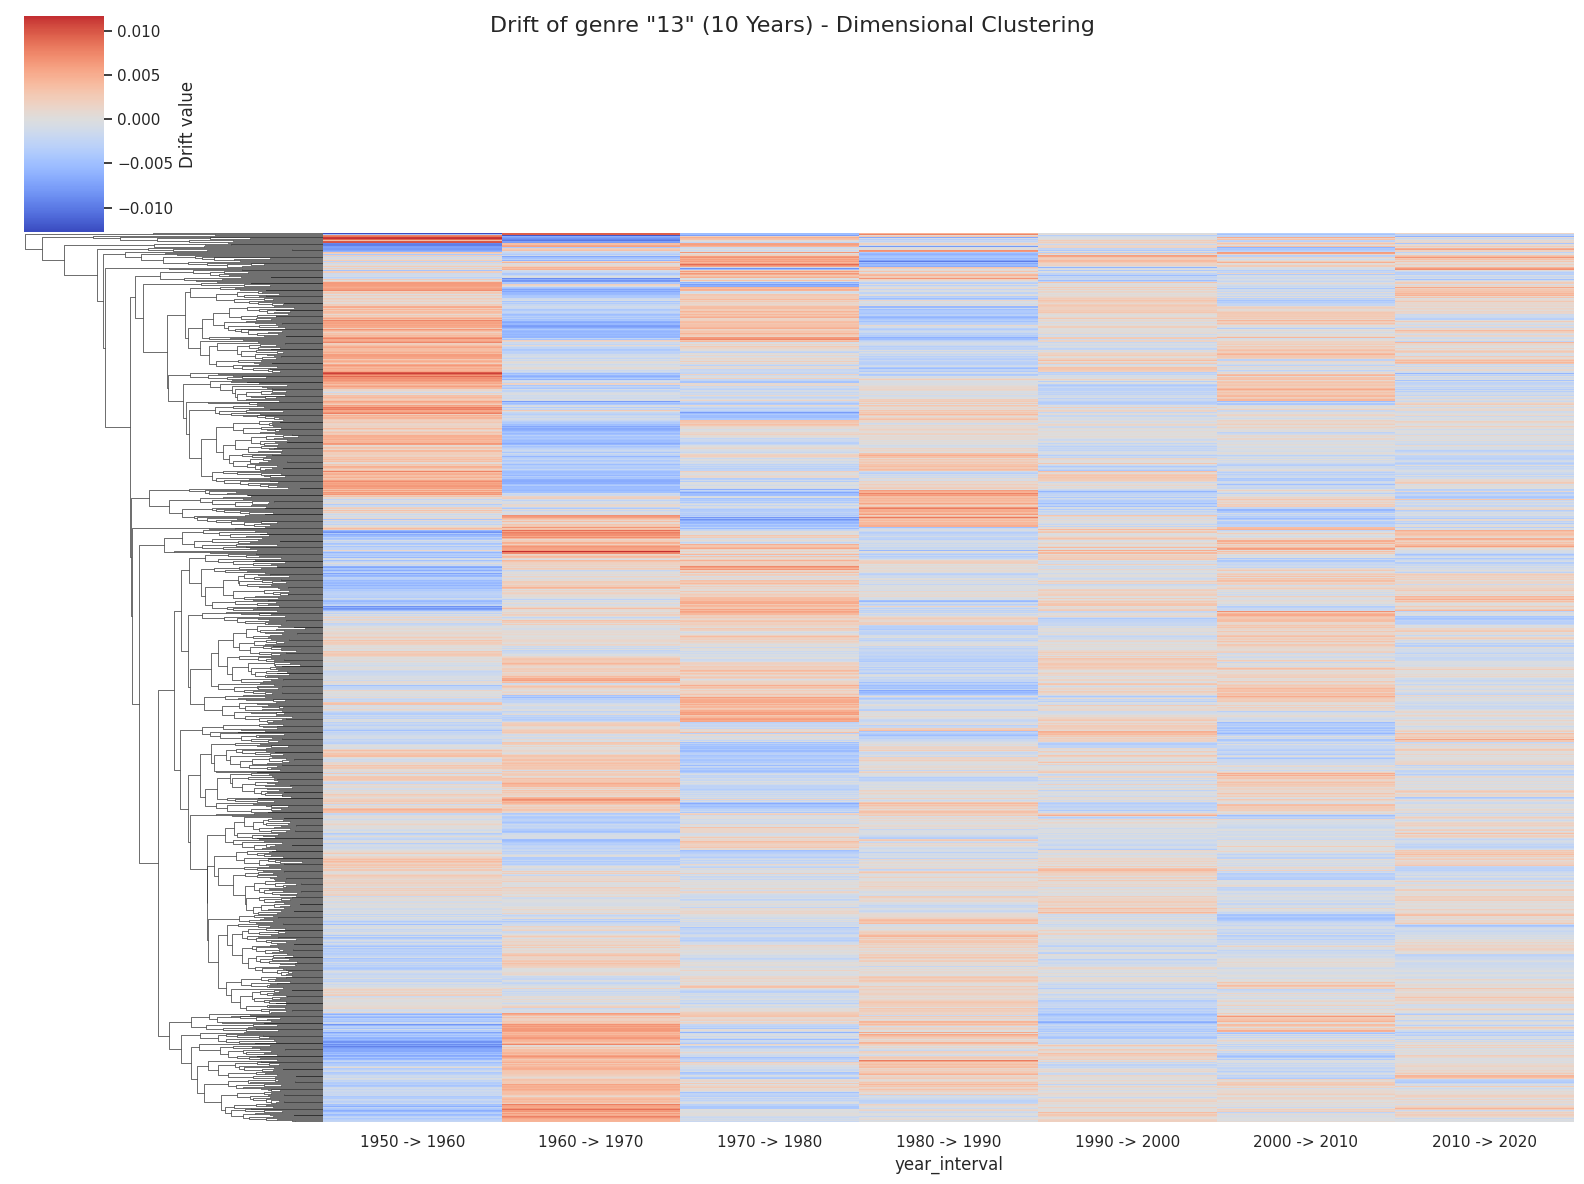

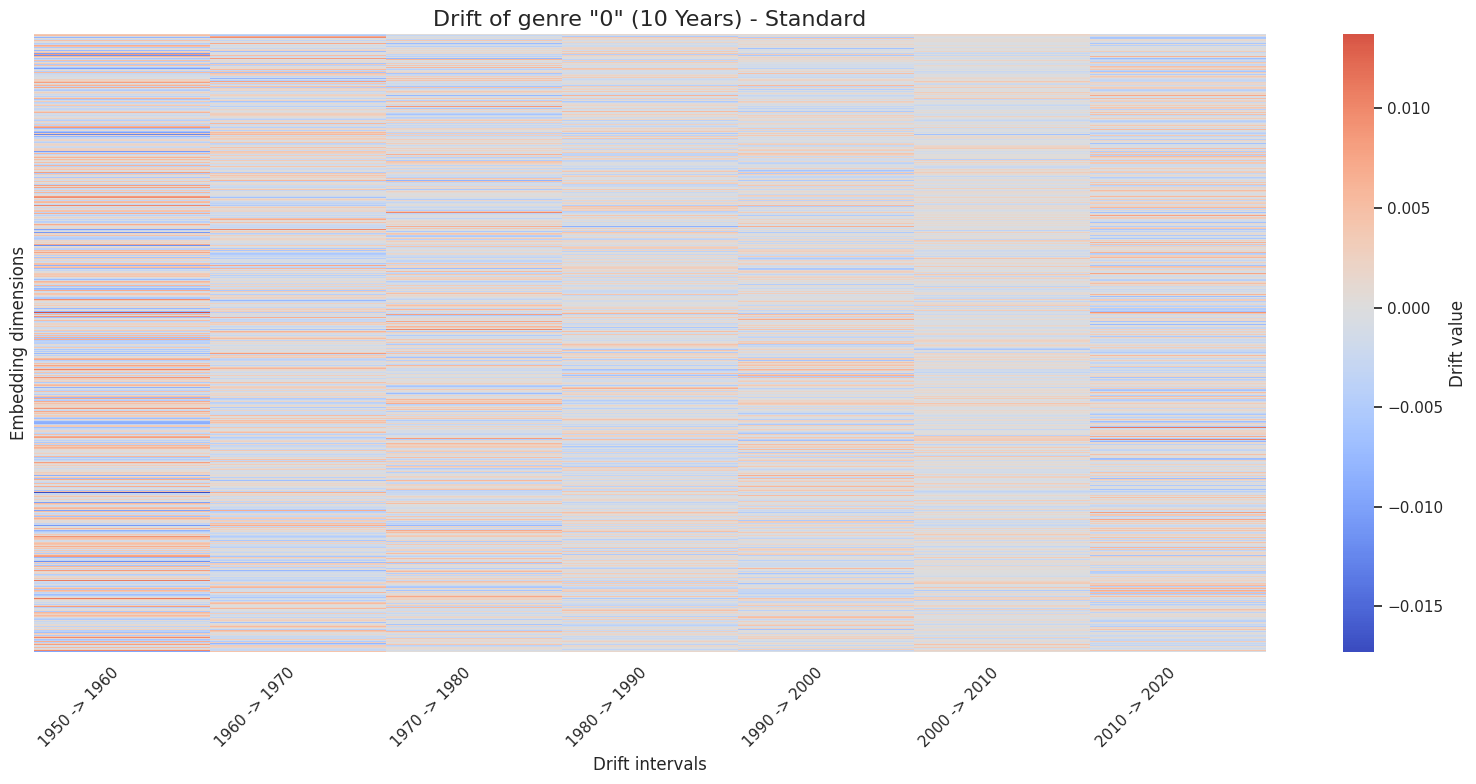

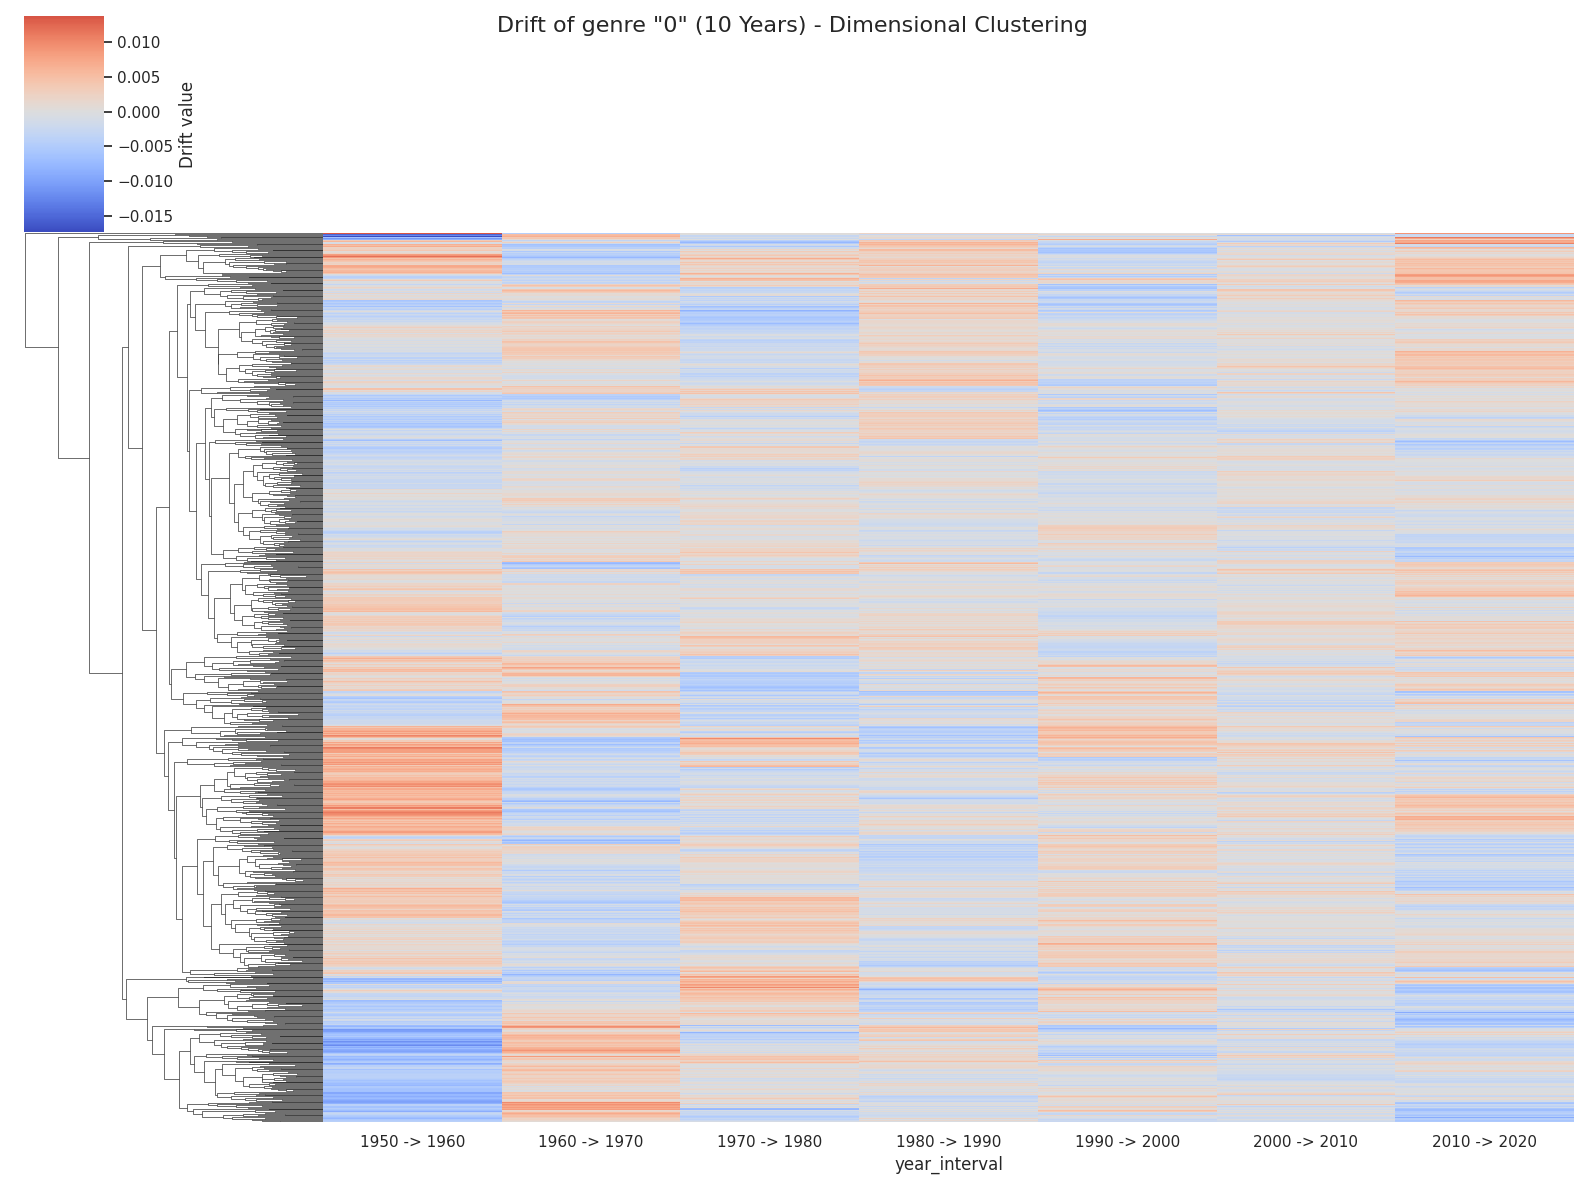

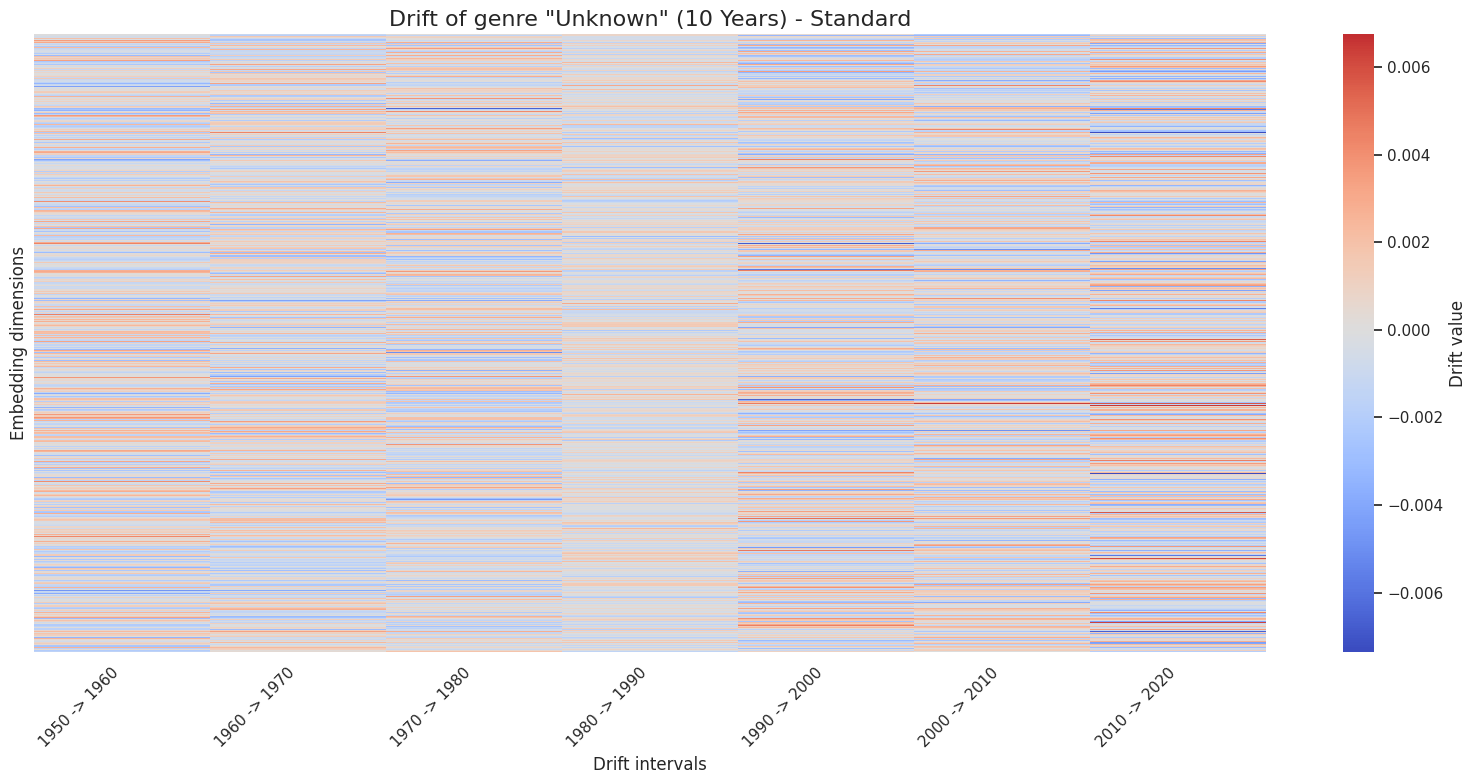

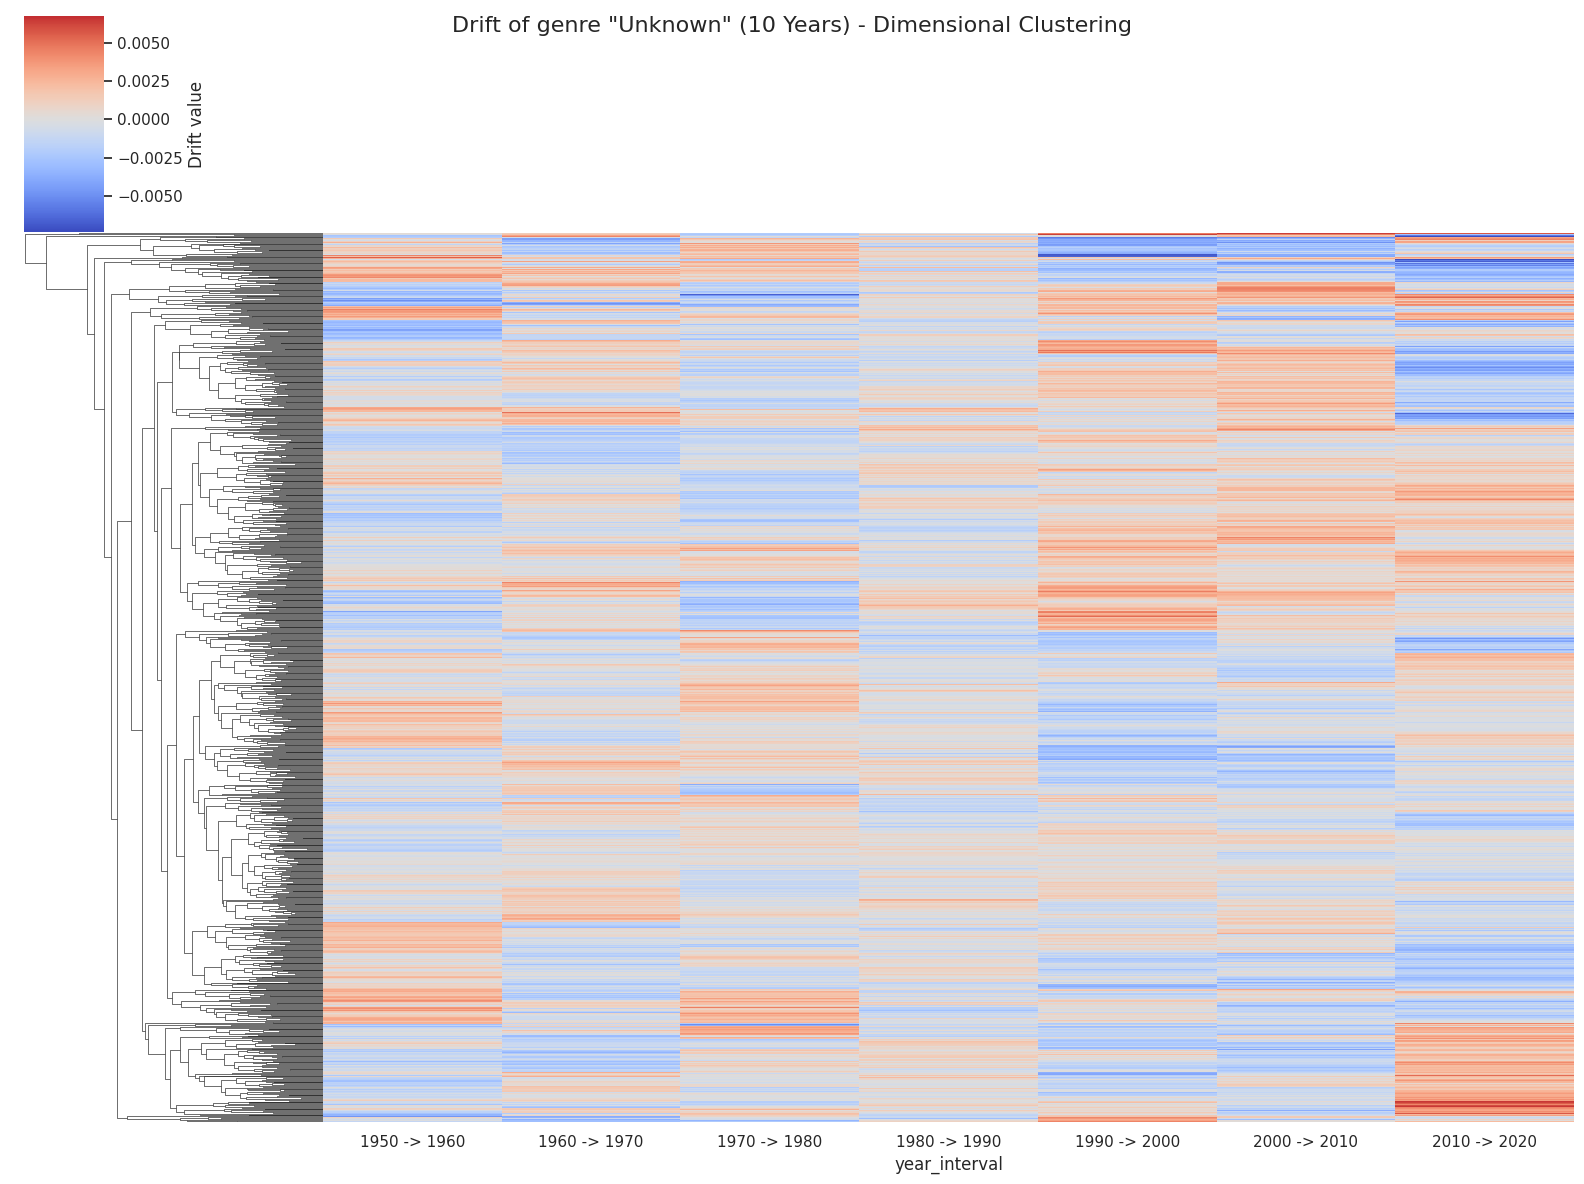

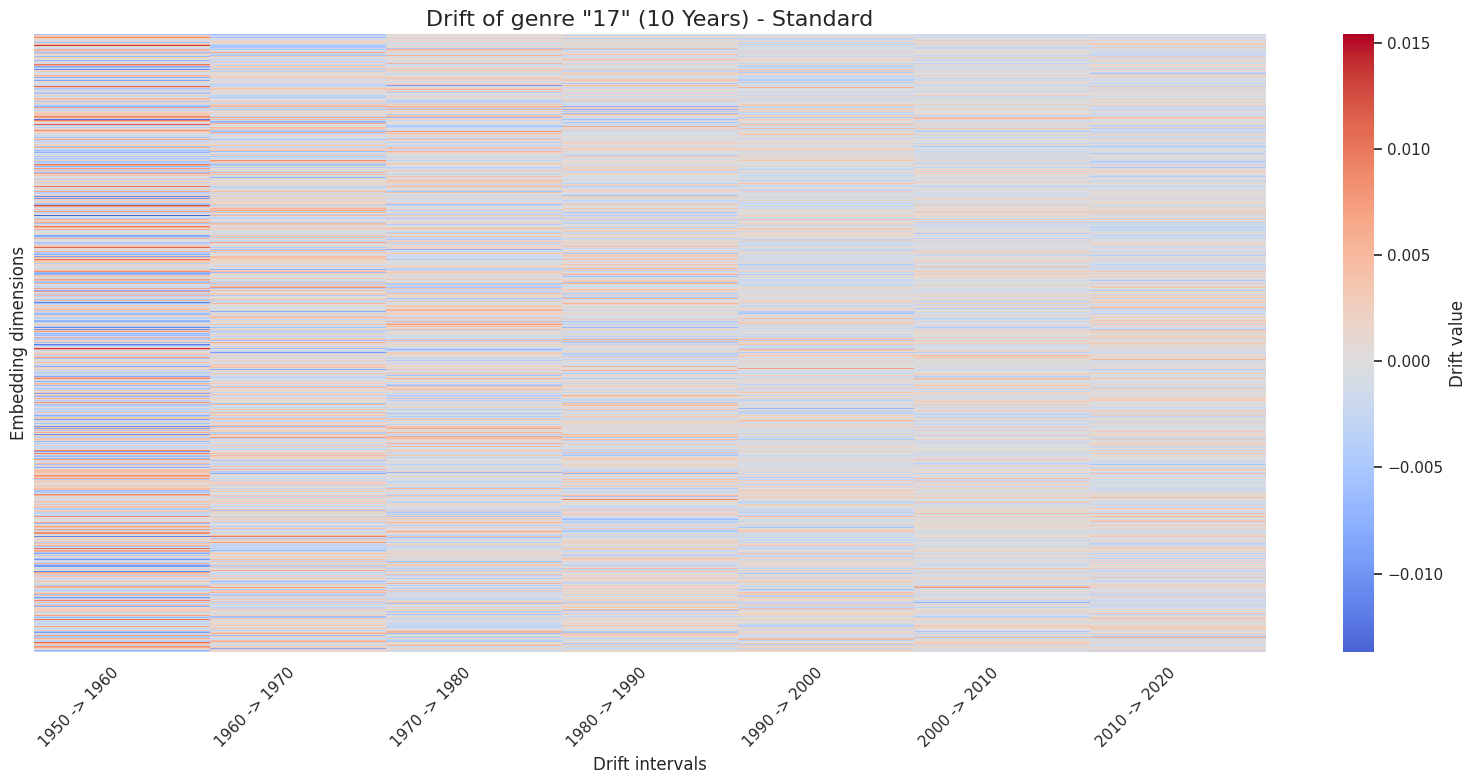

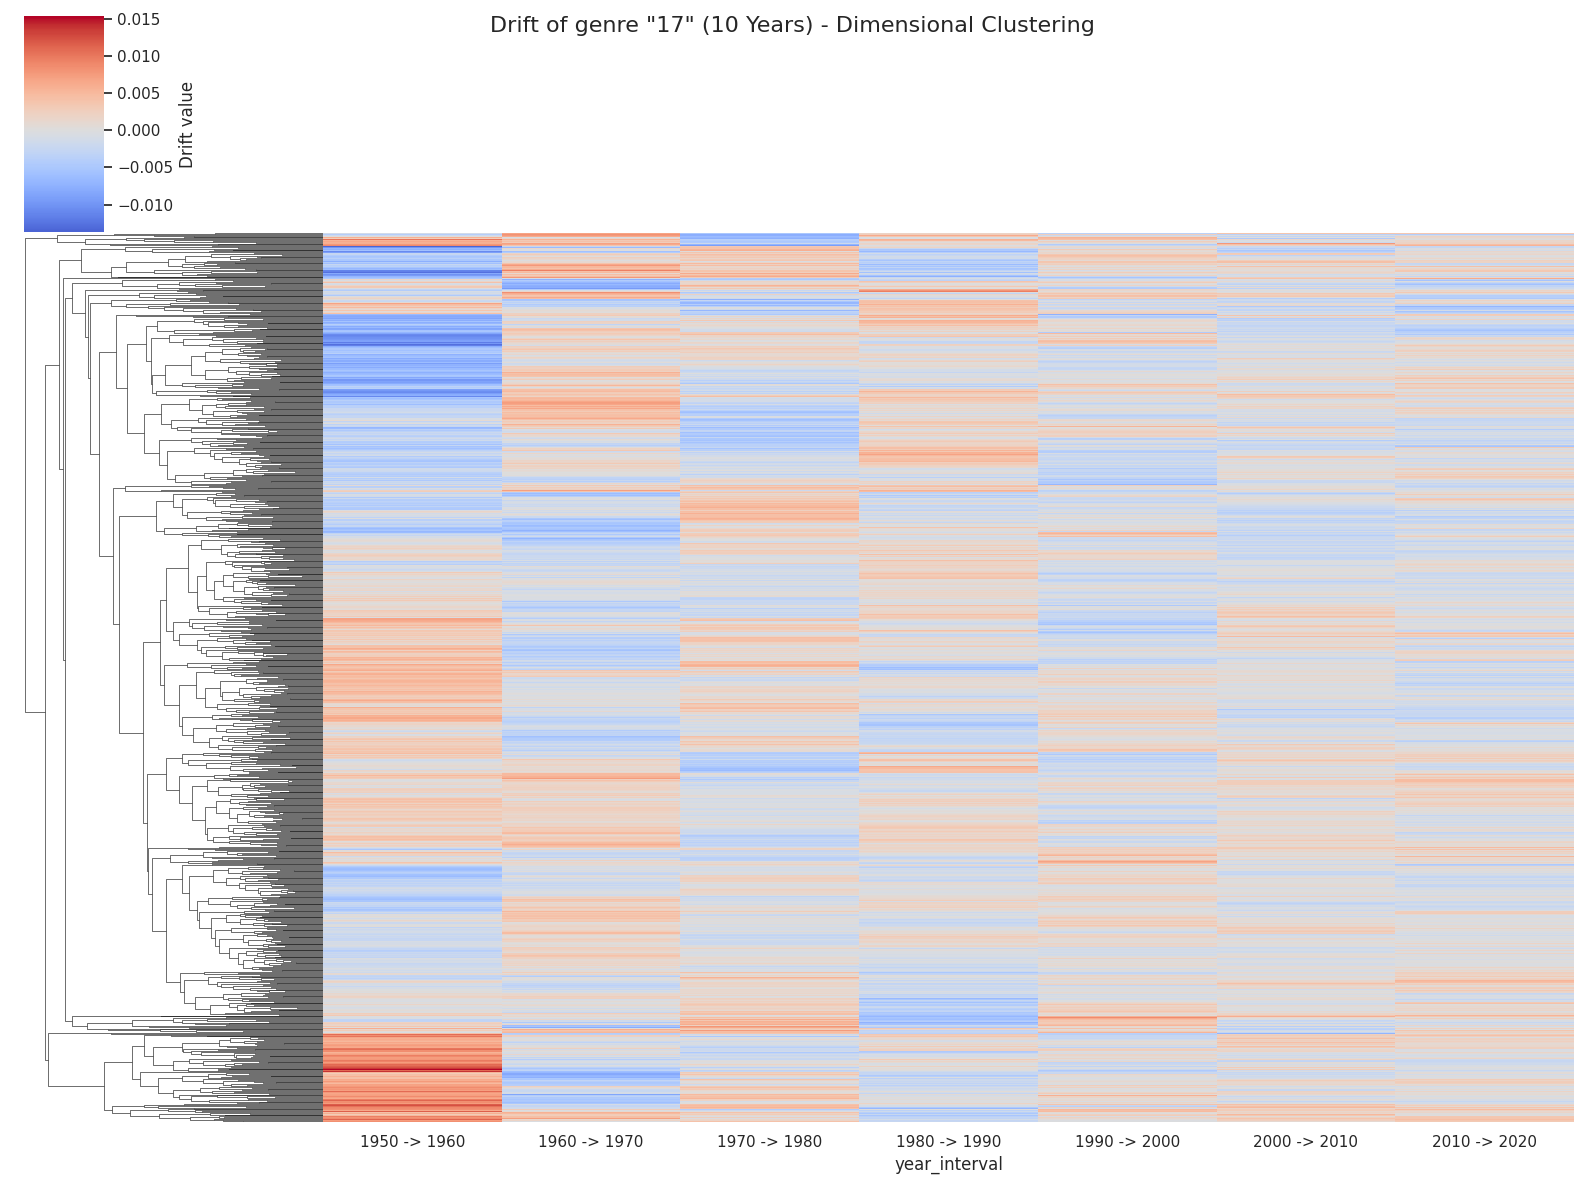

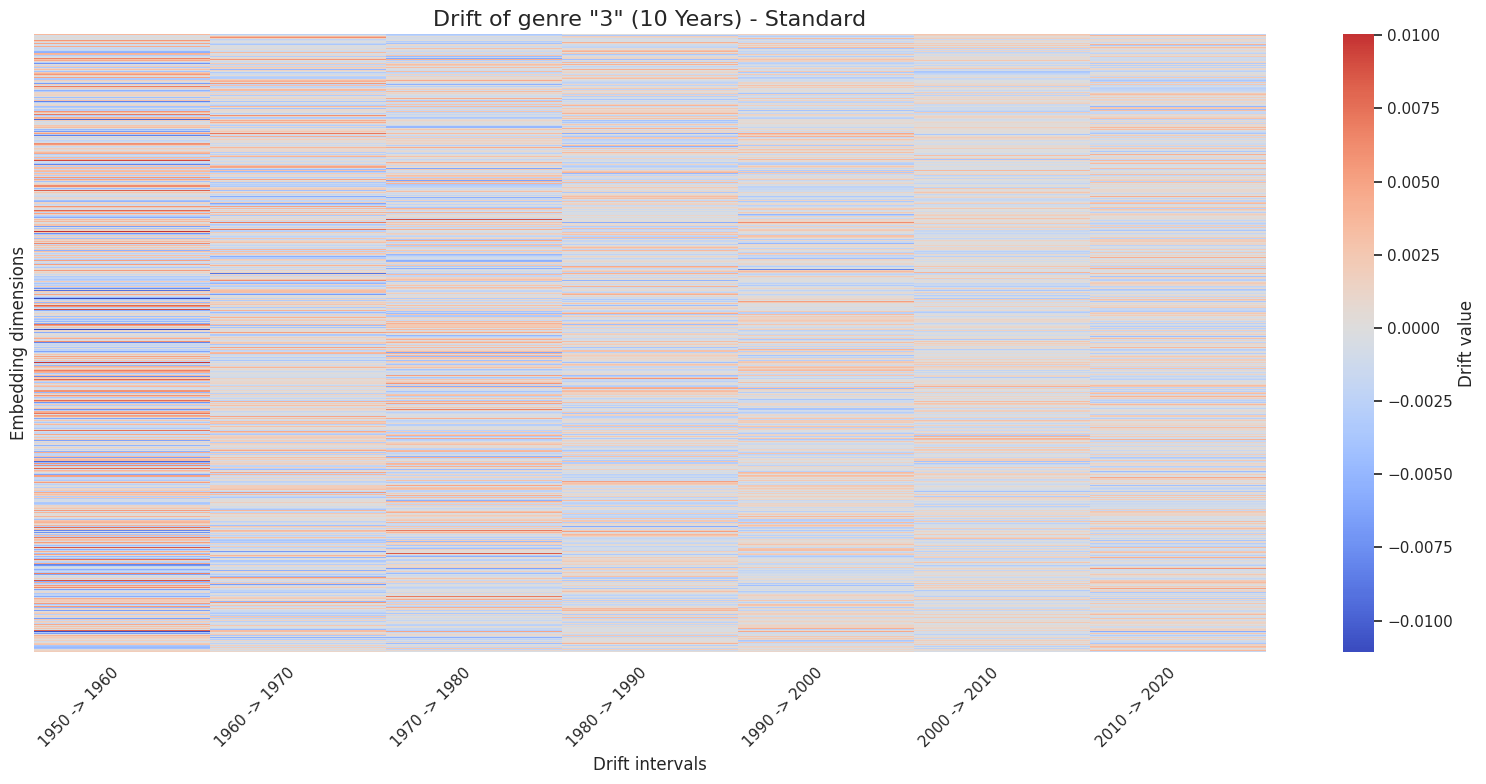

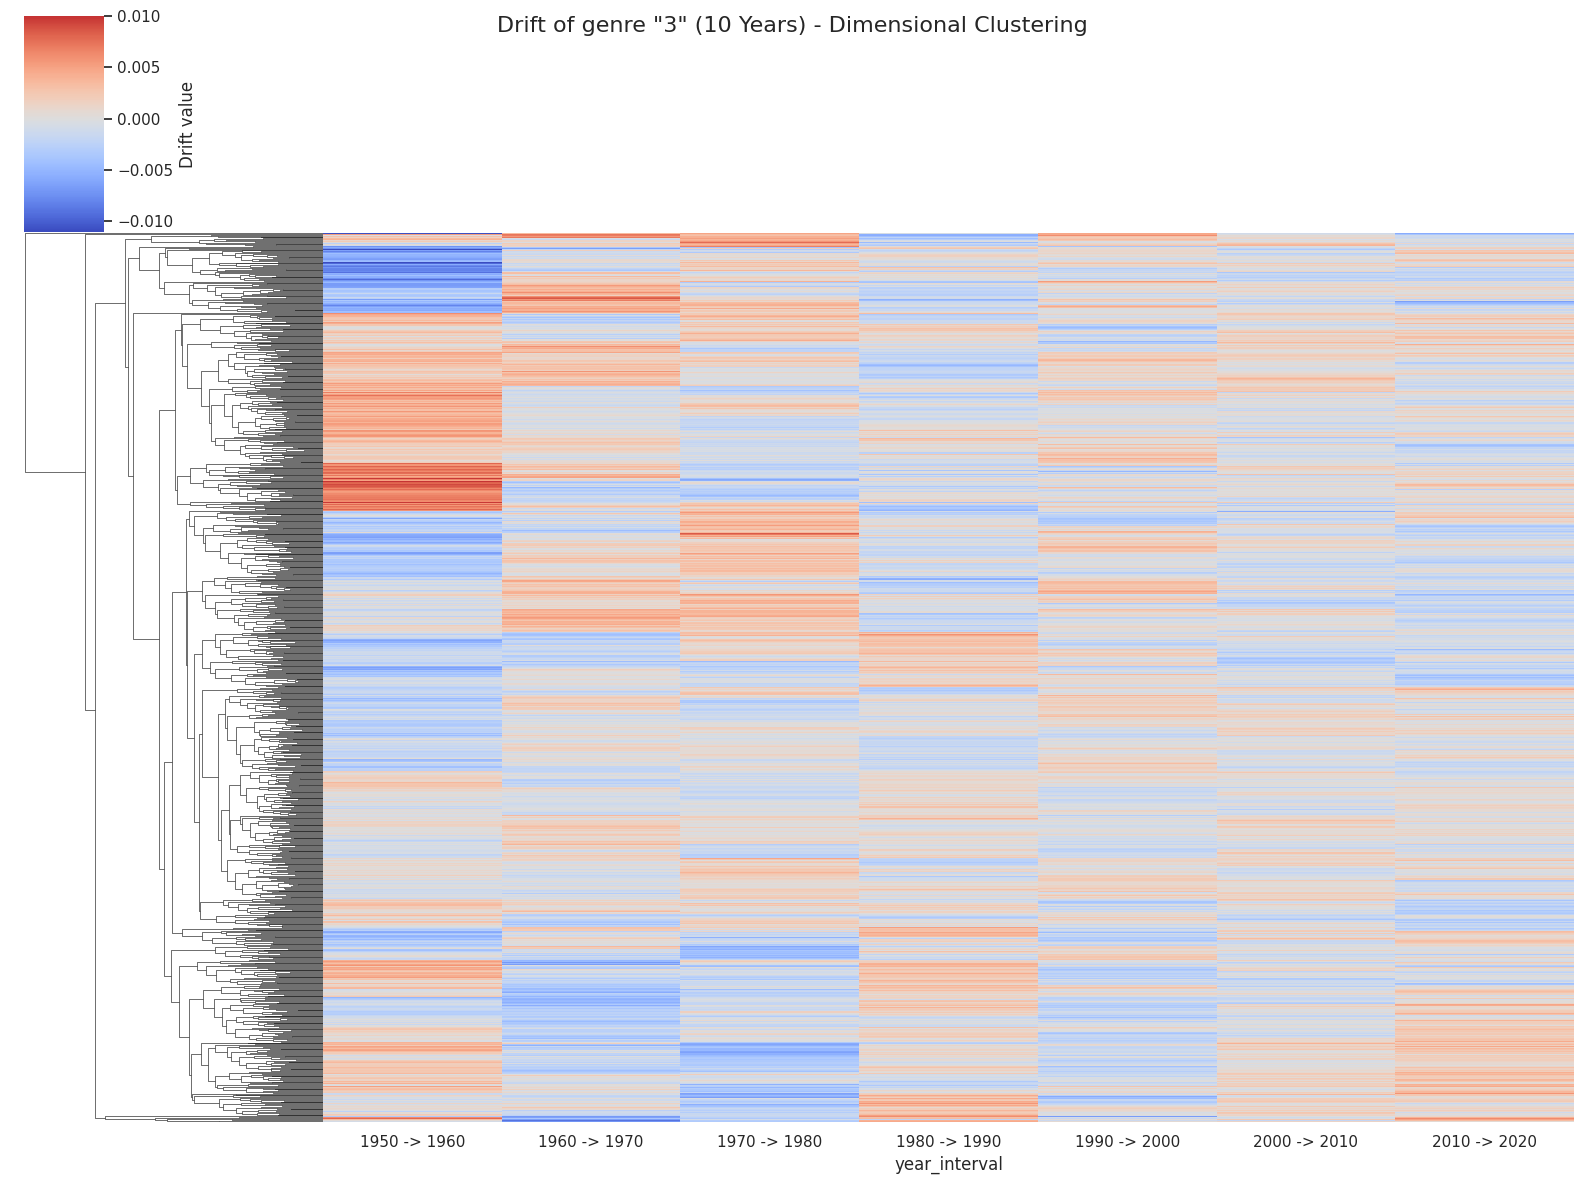

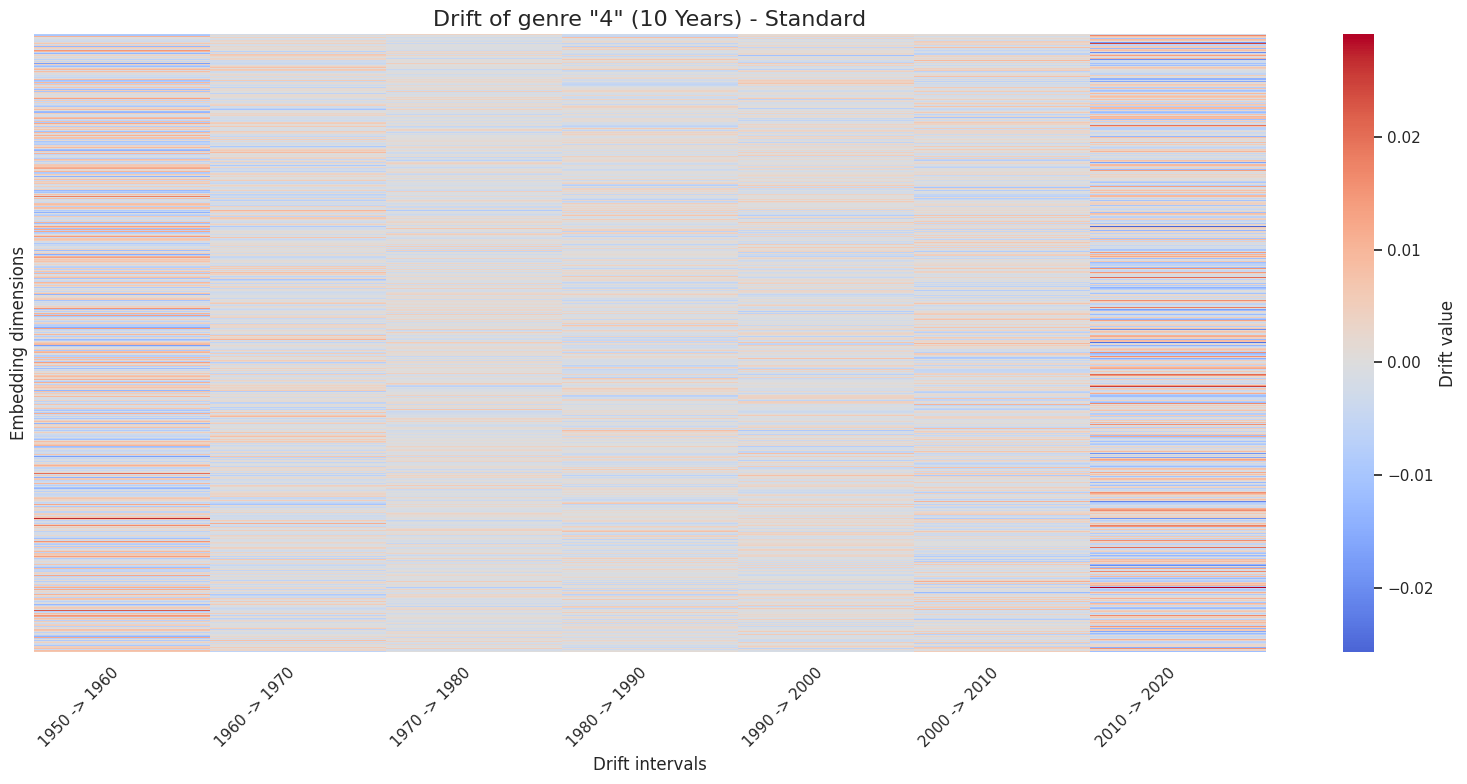

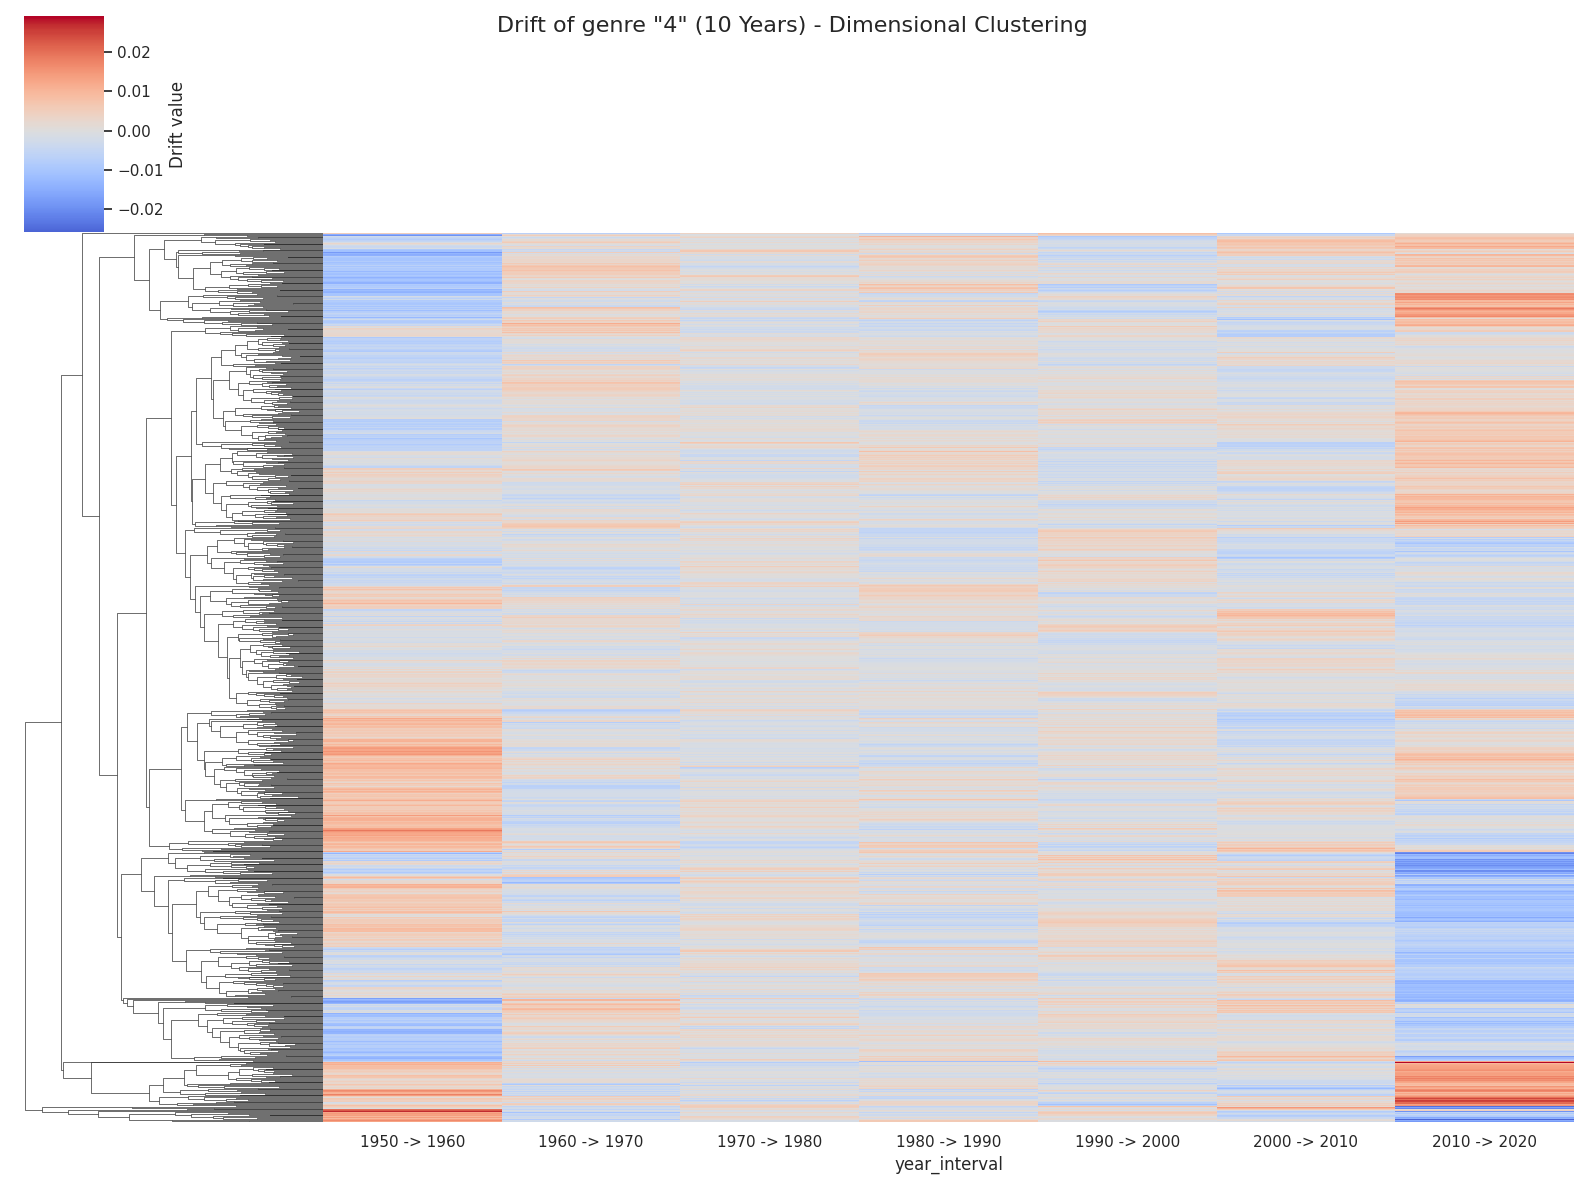

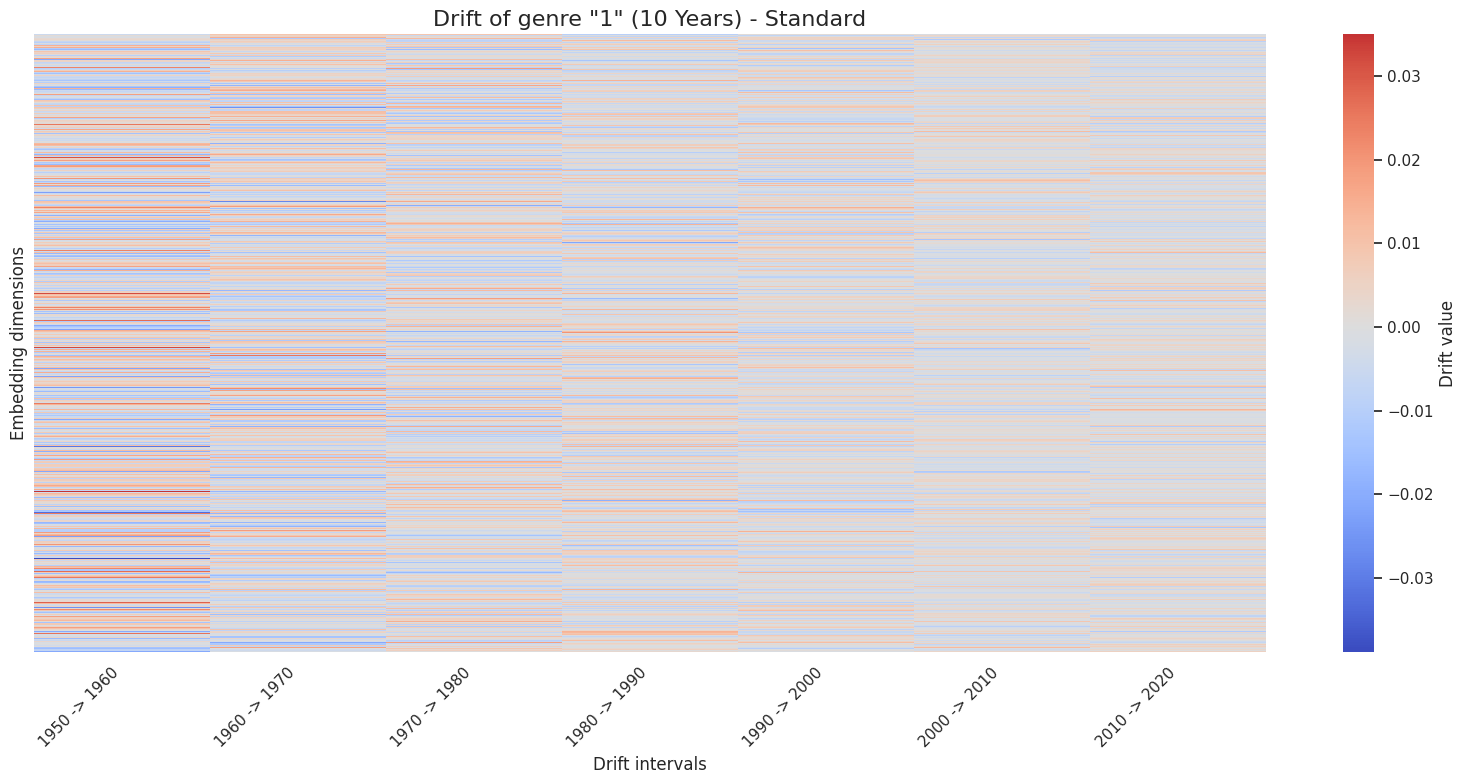

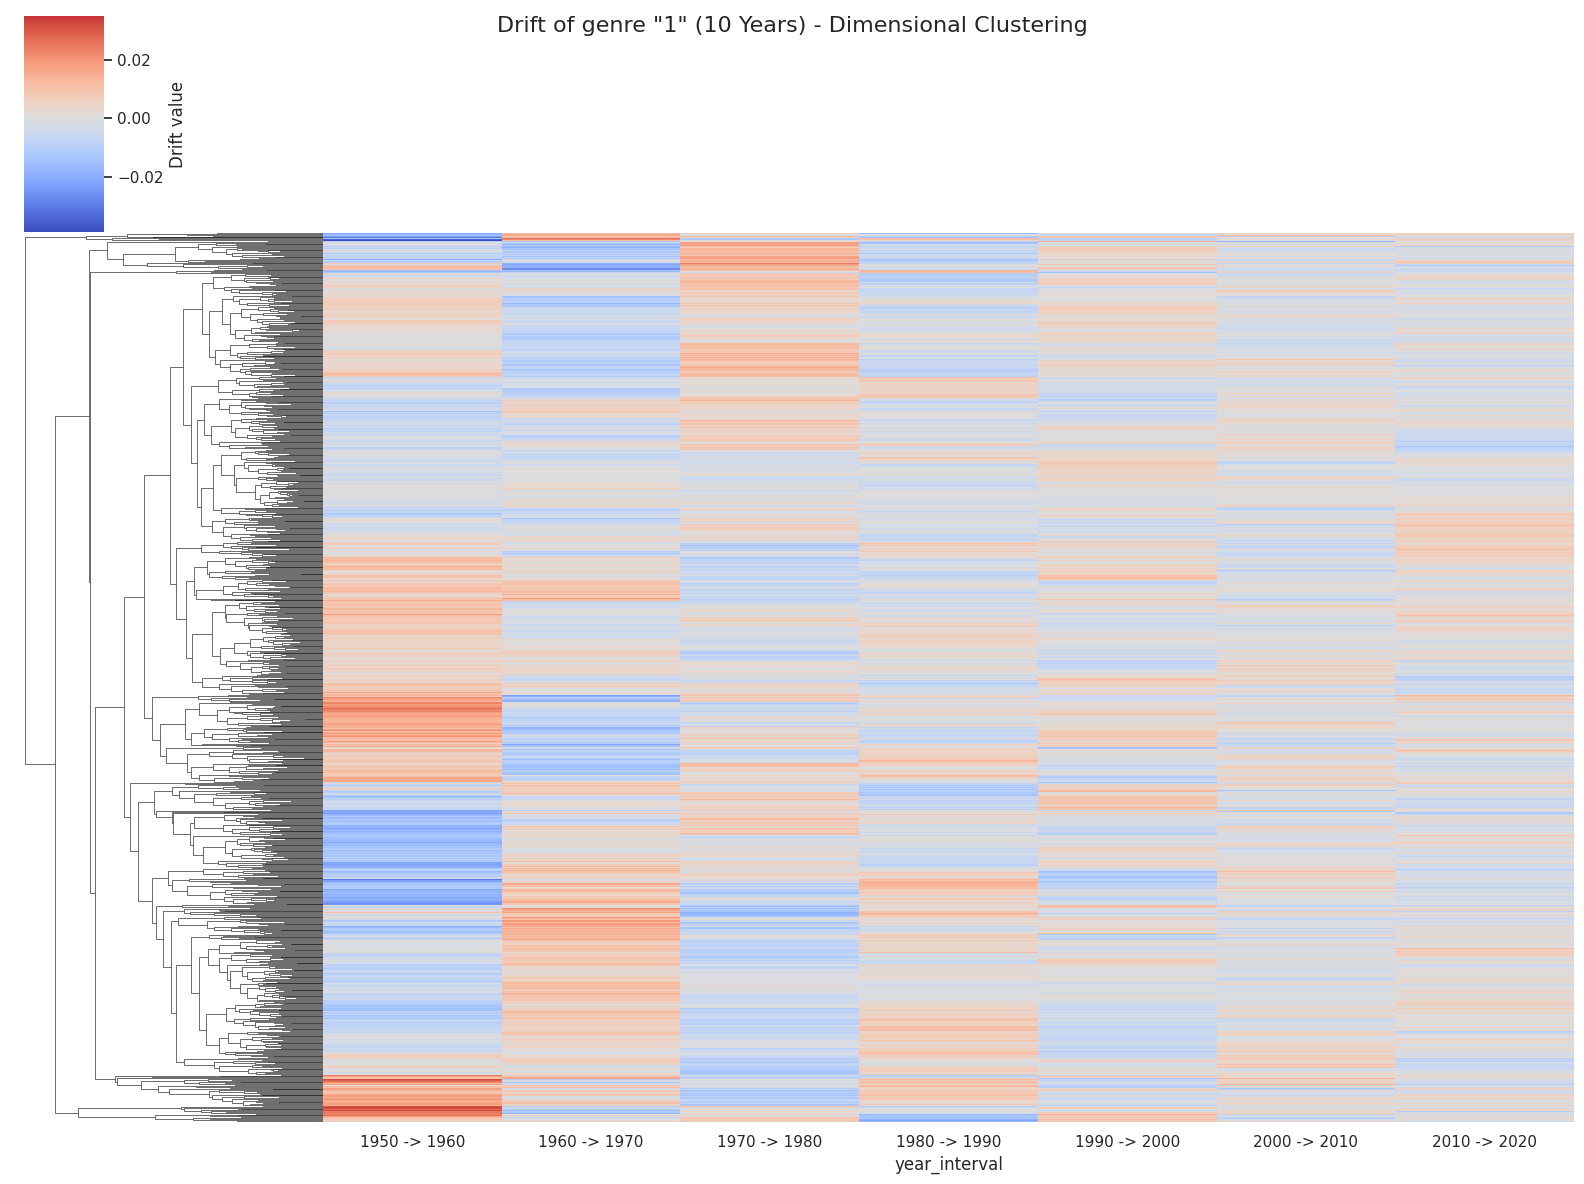

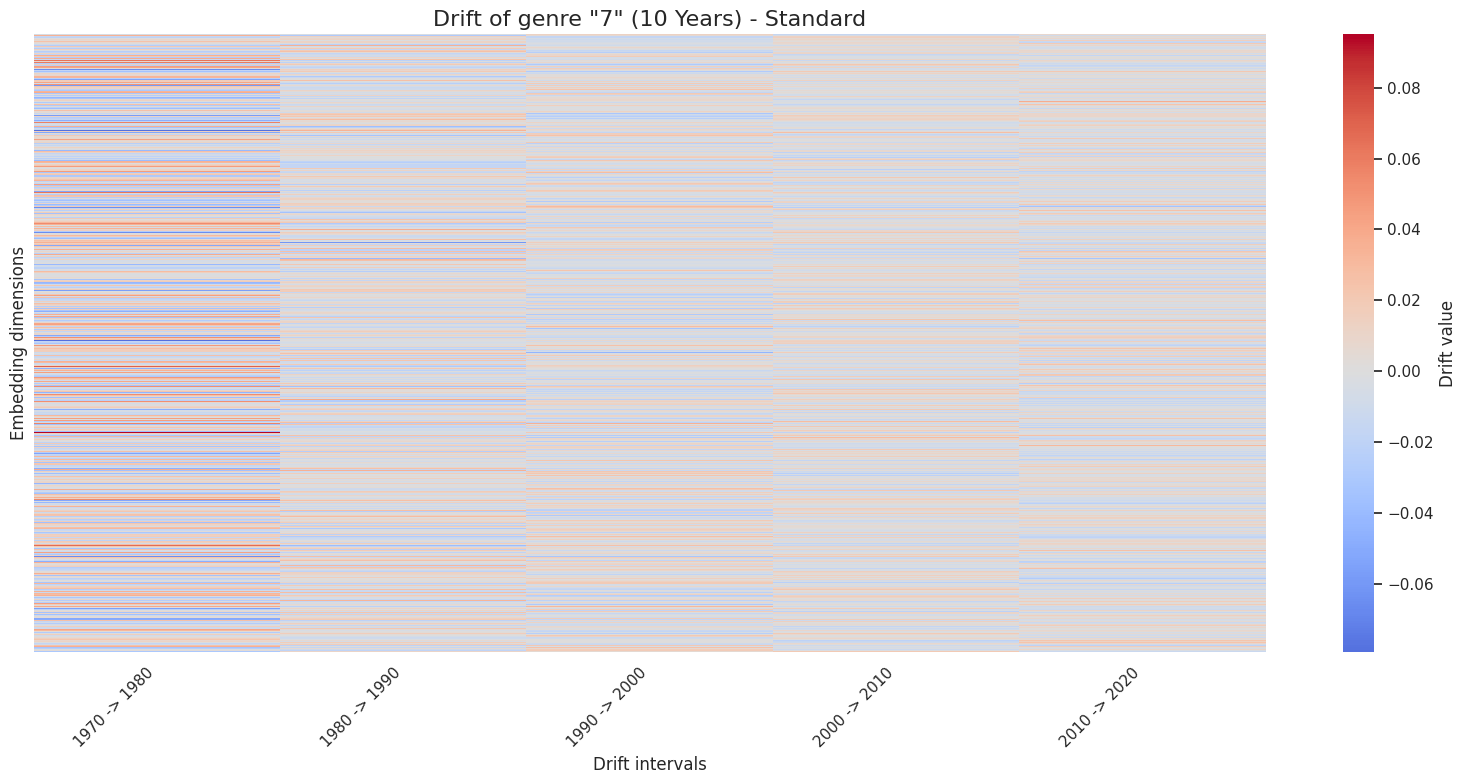

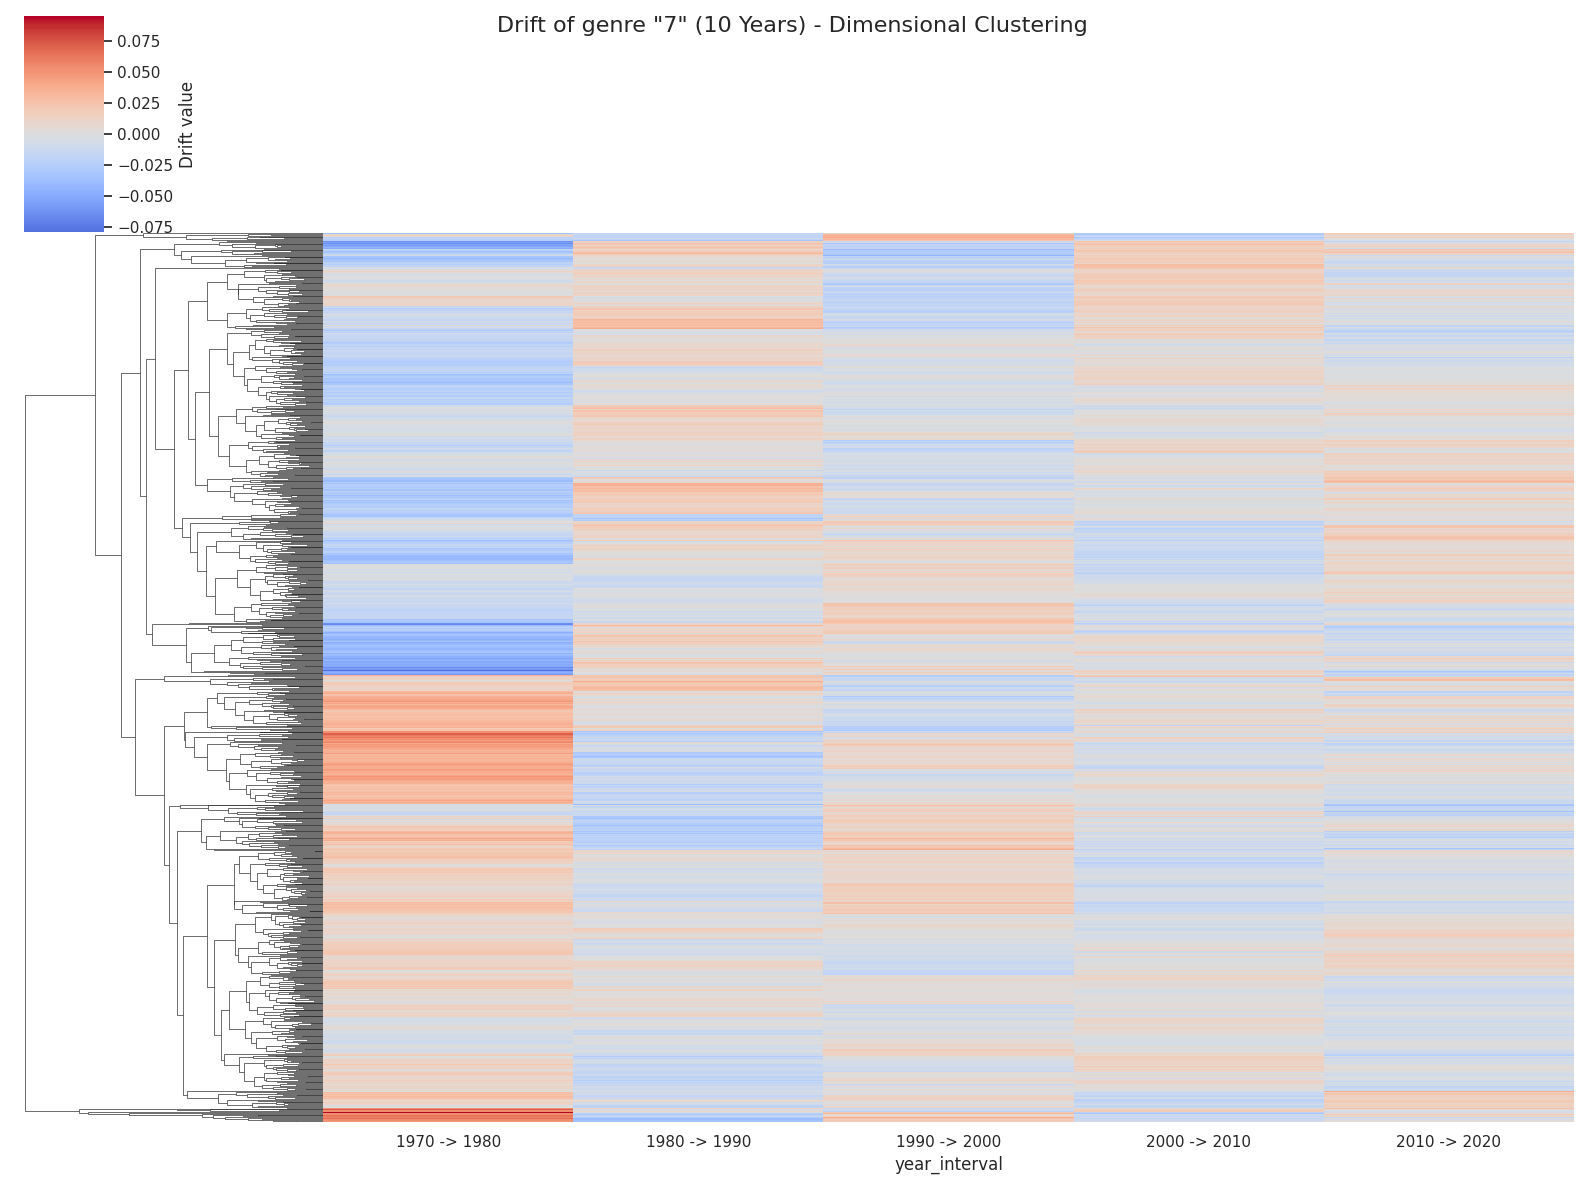

In [3]:
for genre in df_movies['new_genre'].unique():
    plot_data, bin_size = prepare_heatmap_data(group_df, target_genre=genre, bin_size=10)

    plot_standard_heatmap(plot_data, target_genre=genre, bin_size=bin_size)
    plot_clustermap(plot_data, target_genre=genre, bin_size=bin_size)


# Inter-genre distance analysis

THIS IS VIBE CODED, #TODO: CHECK IF THIS IS MAKES SENSE

Calculate each genre pair distance evolution -> are they converging or diverging?

Calculate each genre mean distance with respect to all the others

In [4]:
target_genres = group_df['new_genre'].unique()
convergence_df = calculate_genre_convergence(group_df, bin_size=5, target_genres=target_genres)

print(convergence_df.head(10))

horror_action_trend = convergence_df[(convergence_df['Genre_A'] == 'Horror') & (convergence_df['Genre_B'] == 'Action')]
print(horror_action_trend)

  Genre_A Genre_B  Year_Interval_Start  Cosine_Distance
0       0       1                 1950         0.206055
1       0       1                 1955         0.107910
2       0       1                 1960         0.078613
3       0       1                 1965         0.069336
4       0       1                 1970         0.054199
5       0       1                 1975         0.084961
6       0       1                 1980         0.065918
7       0       1                 1985         0.036621
8       0       1                 1990         0.040039
9       0       1                 1995         0.032715
Empty DataFrame
Columns: [Genre_A, Genre_B, Year_Interval_Start, Cosine_Distance]
Index: []


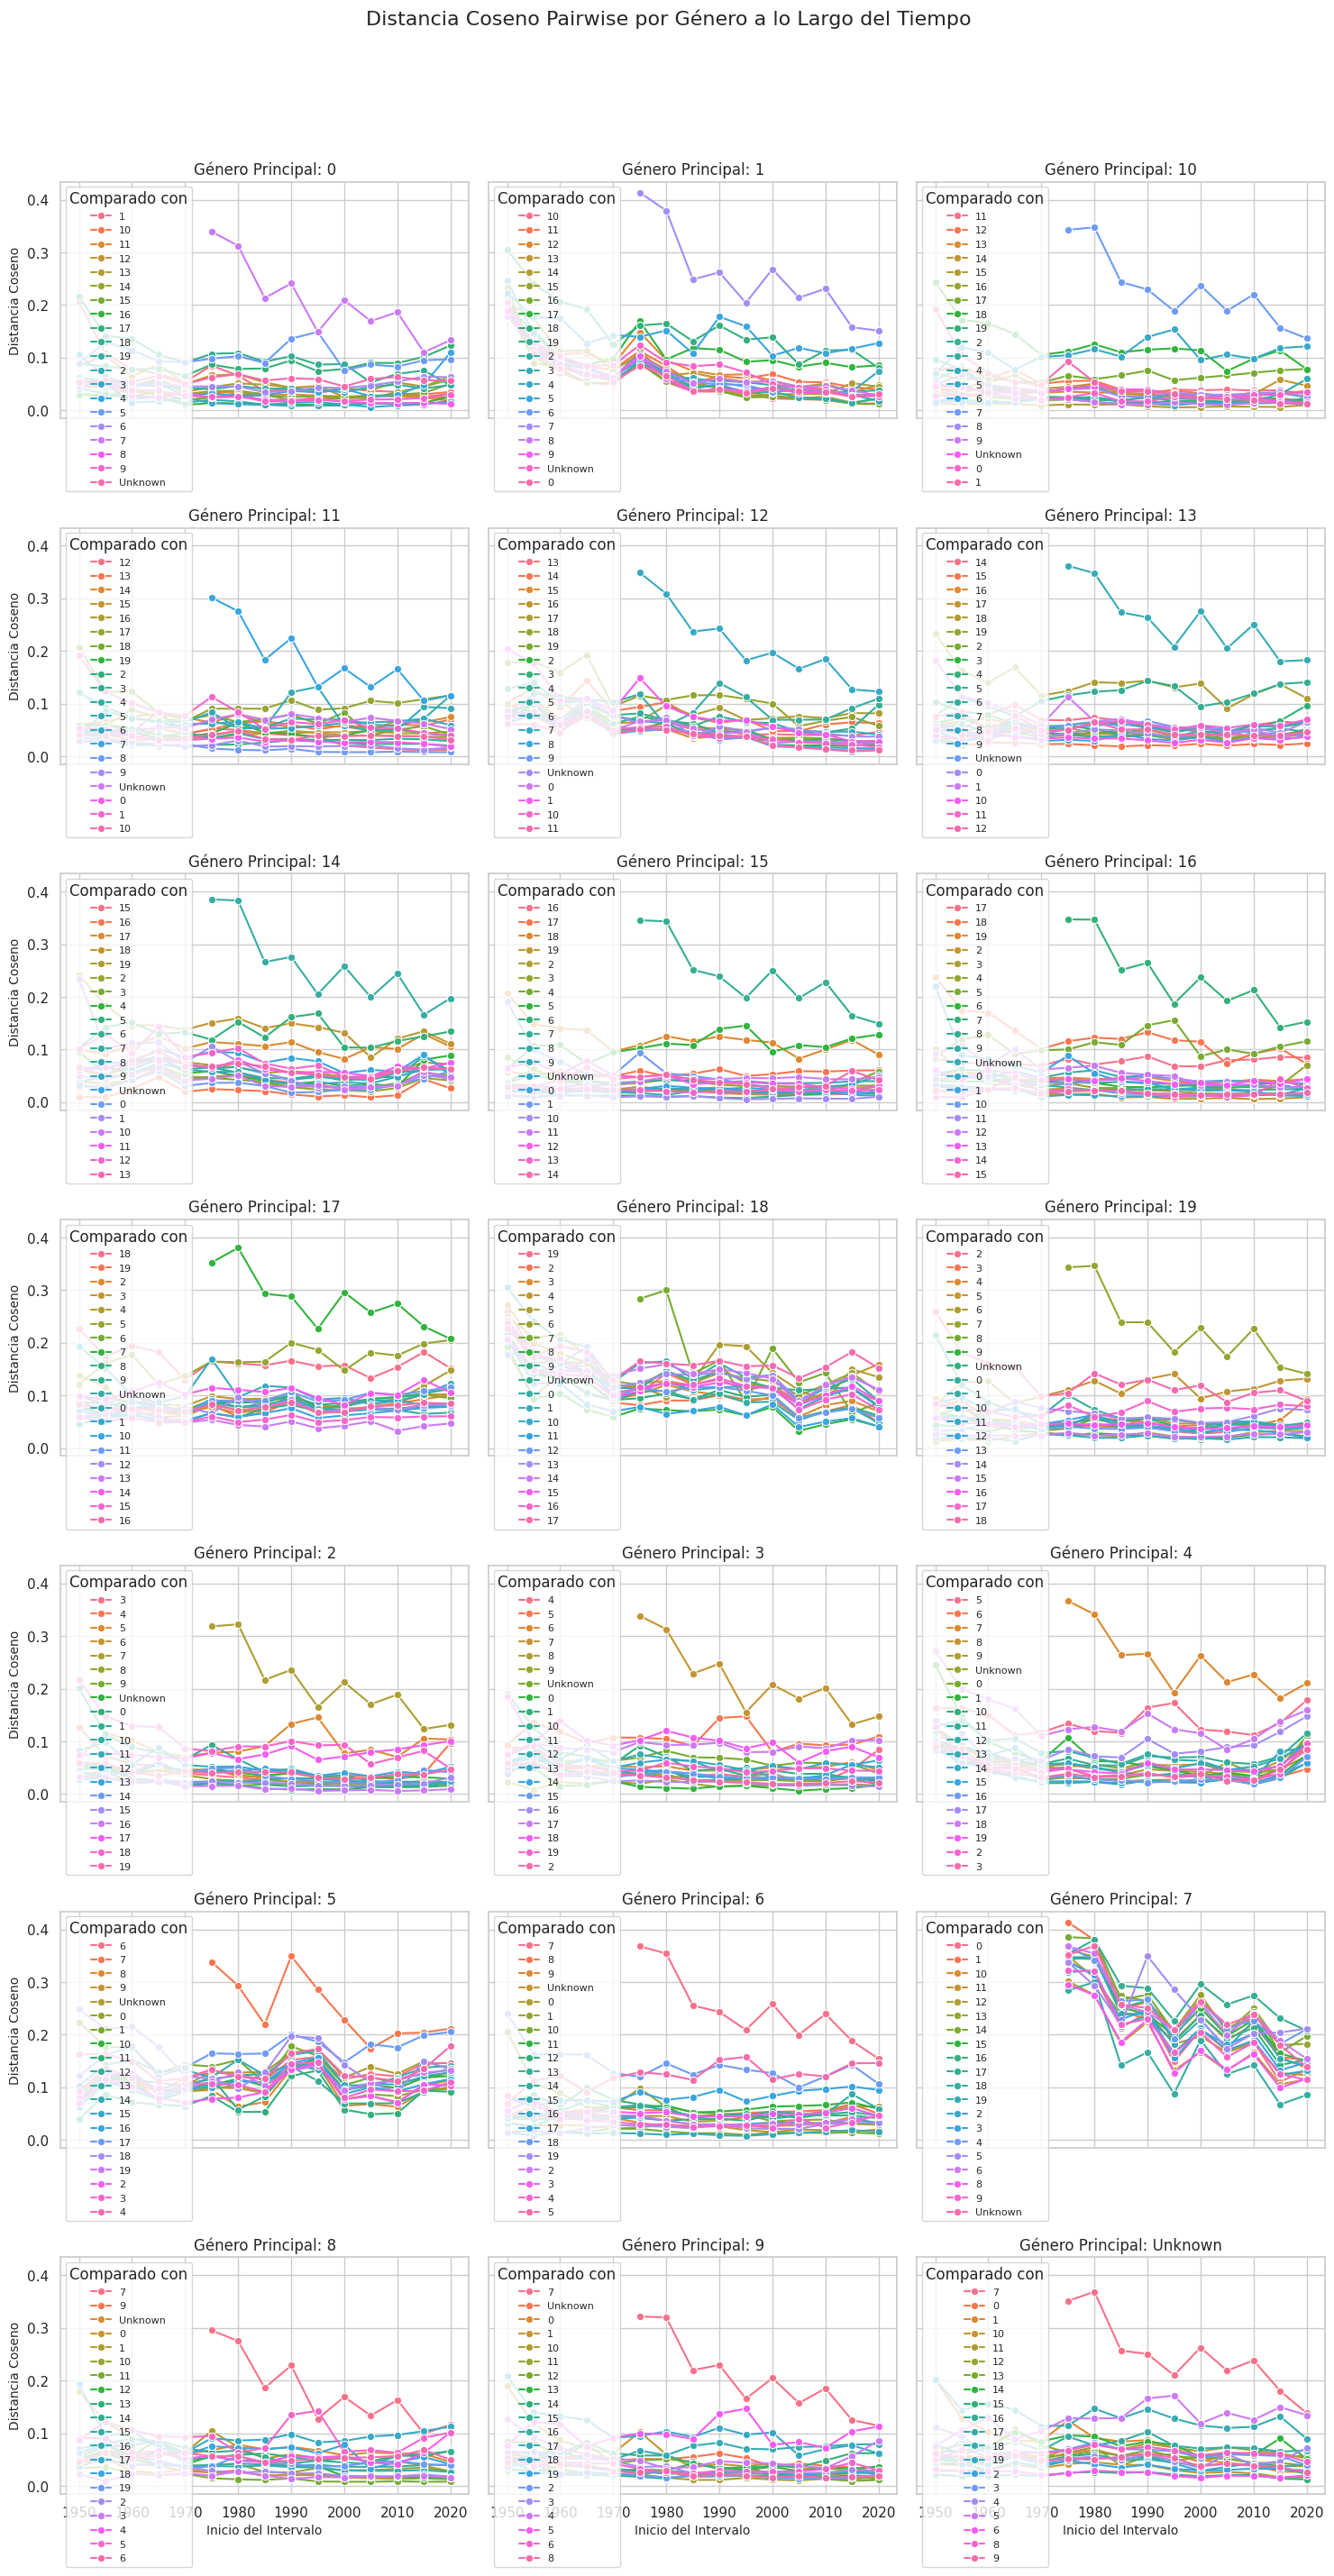

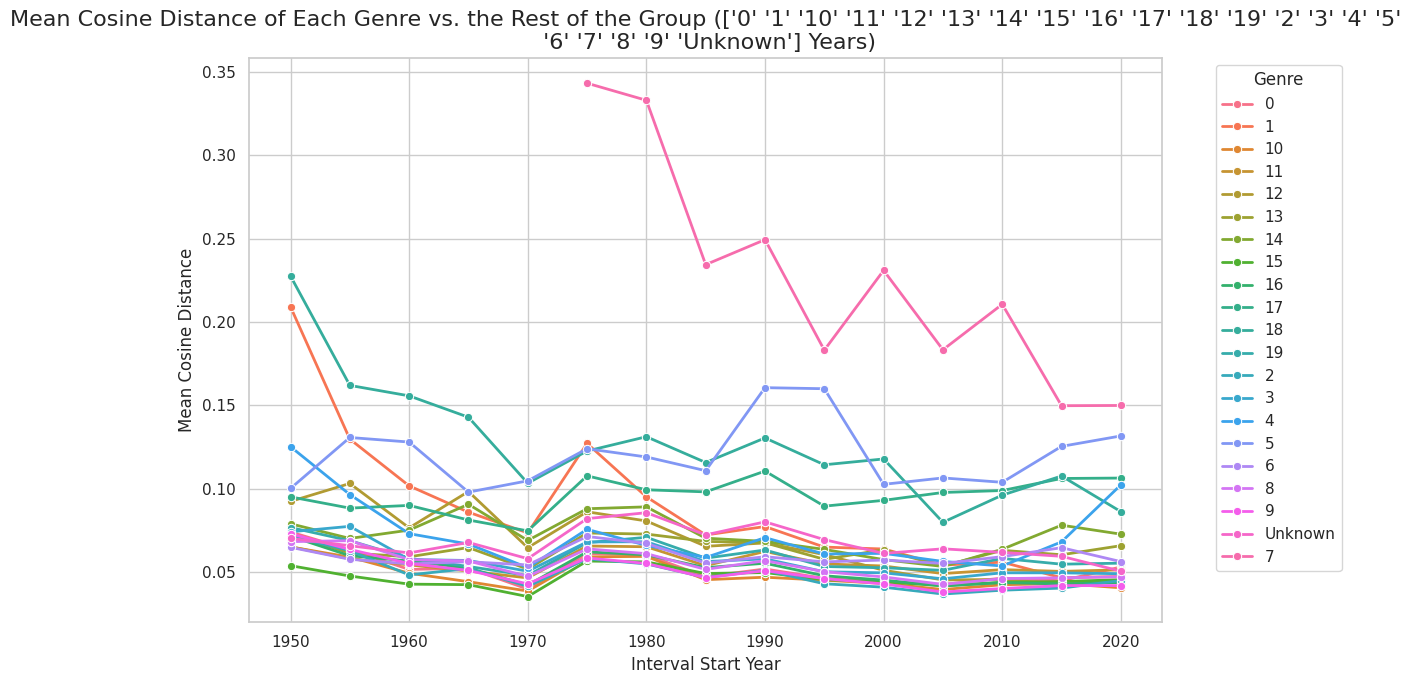

In [5]:
plot_pairwise_convergence(convergence_df, target_genres)
plot_mean_convergence(convergence_df, target_genres)